In [127]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import pandas as pd
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Differentiate and integrate

In [24]:
stimuli = np.random.RandomState(seed=0).randint(0,2,size=21)
stimuli = 2*stimuli - 1
func_stim = lambda t: stimuli[int(t)] if t%1<0.5 else 0
syn_fb = 0.2
radius = 2

network = nengo.Network(seed=0)
with network:
    node_stim = nengo.Node(func_stim)
    
    ens_stim = nengo.Ensemble(1000, 1)
    ens_delta = nengo.Ensemble(1000, 1, encoders=nengo.dists.Choice([[1]]), intercepts=nengo.dists.Uniform(0,1))
    ens_memory = nengo.Ensemble(2000, 1, radius=radius)    
    conn_stim = nengo.Connection(node_stim, ens_stim)
    conn_delta1 = nengo.Connection(ens_stim, ens_delta, synapse=0.01, function=lambda x: 2*np.abs(x))
    conn_delta2 = nengo.Connection(ens_stim, ens_delta, synapse=0.1, function=lambda x: -2*np.abs(x))
    conn_memff = nengo.Connection(ens_delta, ens_memory, synapse=syn_fb, transform=syn_fb)
    conn_memfb = nengo.Connection(ens_memory, ens_memory, synapse=syn_fb)
    
    probe_stim = nengo.Probe(ens_stim, synapse=0.01)
    probe_delta = nengo.Probe(ens_delta, synapse=0.01)
    probe_memory = nengo.Probe(ens_memory, synapse=0.01)
sim = nengo.Simulator(network, dt=0.001)
with sim:
    sim.run(10)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

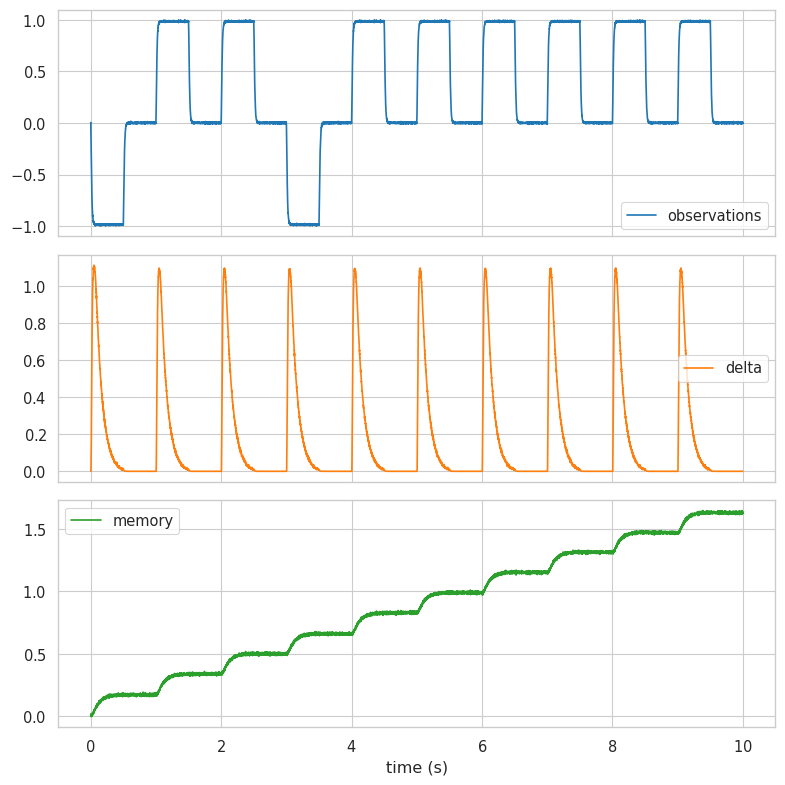

In [25]:
with sns.axes_style("whitegrid"):  # This enables gridlines
    fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(8,8))
    sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_stim].flatten(), label='observations', color=palette[0], ax=axes[0])
    sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_delta].flatten(), label='delta', color=palette[1], ax=axes[1])
    sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_memory].flatten(), label='memory', color=palette[2], ax=axes[2])
    axes[2].set(xlabel='time (s)')
    plt.grid(True, axis='y')  # Enable only y-axis gridlines
    fig.tight_layout()

# Learn mapping from N to 1/N

In [65]:
stimuli = np.random.RandomState(seed=0).randint(1,6,size=10000)
func_stim = lambda t: stimuli[int(t*10)]
func_weight = lambda x: 1/(x+3) if x!=-3 else 1
func_stop = lambda t: 1 if t>T/2 else 0
syn_fb = 0.2
radius = 6
a = 1e-4
T = 100

network = nengo.Network(seed=0)
with network:
    node_stim = nengo.Node(func_stim)
    node_target = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
    node_stop = nengo.Node(func_stop)
    
    ens_memory = nengo.Ensemble(2000, 1, radius=radius)
    ens_weight = nengo.Ensemble(2000, 1)
    ens_error = nengo.Ensemble(2000, 1)
    conn_stim = nengo.Connection(node_stim, ens_memory)
    conn_weight = nengo.Connection(ens_memory, ens_weight, synapse=0.01,
                                   function=lambda x: 0, learning_rule_type=nengo.PES(learning_rate=a))

    conn_perfect = nengo.Connection(node_stim, node_target, function=func_weight)
    conn_error1 = nengo.Connection(node_target, ens_error, transform=1)
    conn_error2 = nengo.Connection(ens_weight, ens_error, transform=-1)
    conn_learning = nengo.Connection(ens_error, conn_weight.learning_rule, transform=-1)
    conn_stop = nengo.Connection(node_stop, ens_error.neurons, transform=-1000*np.ones((ens_error.n_neurons, 1)))
    
    probe_stim = nengo.Probe(node_stim, synapse=0.01)
    probe_target = nengo.Probe(node_target, synapse=0.01)
    probe_memory = nengo.Probe(ens_memory, synapse=0.01)
    probe_weight = nengo.Probe(ens_weight, synapse=0.01)
    probe_error = nengo.Probe(ens_error, synapse=0.01)
    probe_learned_weights = nengo.Probe(conn_weight, "weights")

sim = nengo.Simulator(network, dt=0.001)
with sim:
    sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

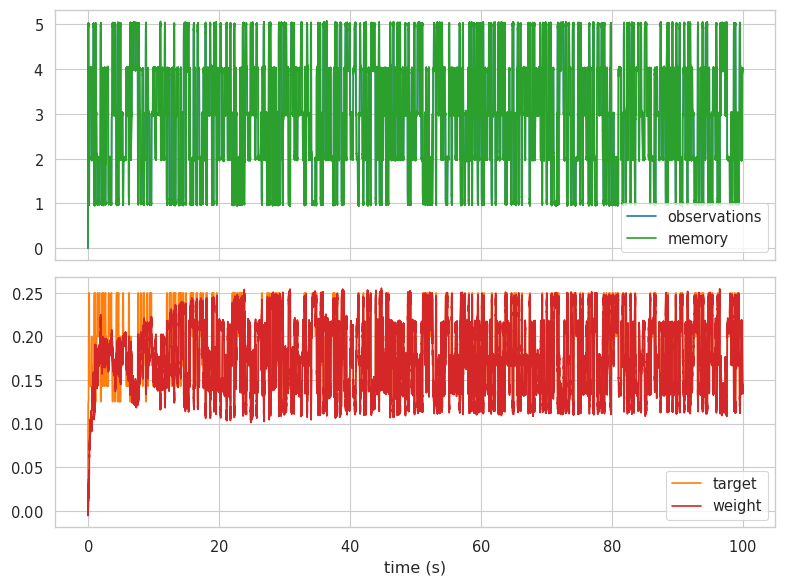

In [64]:
with sns.axes_style("whitegrid"):  # This enables gridlines
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(8,6))
    sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_stim].flatten(), label='observations', color=palette[0], ax=axes[0])
    sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_target].flatten(), label='target', color=palette[1], ax=axes[1])
    sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_memory].flatten(), label='memory', color=palette[2], ax=axes[0])
    sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_weight].flatten(), label='weight', color=palette[3], ax=axes[1])
    axes[1].set(xlabel='time (s)')
    plt.grid(True, axis='y')  # Enable only y-axis gridlines
    fig.tight_layout()

In [66]:
learned_weights = sim.data[probe_learned_weights][-1]

In [70]:
learned_weights.shape

(1, 2000)

In [73]:
np.where(learned_weights==0)[1].shape

(605,)

# Use PES to learn f(x) = 1/N

In [128]:
class EnvironmentRec():
    def __init__(self, dataset, sid, trial, T=1, dt=0.001, dim_context=5, seed_env=0):
        self.T = T
        self.dt = dt
        self.sid = sid
        self.trial = trial
        self.dataset = dataset
        self.empirical = pd.read_pickle(f"data/{dataset}.pkl").query("sid==@sid & trial==@trial")
        self.dim_context = dim_context
        self.rng = np.random.RandomState(seed=seed_env)
        self.context = self.rng.rand(self.dim_context)
        self.context = self.context / np.linalg.norm(self.context)
        if self.dataset=='carrabin':
            self.Tall = 5*self.T - self.dt
            self.stages = range(1, 6)
        # create input arrays
        self.colors = []
        self.weights = []
        tt = int(self.T / self.dt / 2)
        if self.dataset=='carrabin':
            for stage in self.stages:
                color = self.empirical.query("stage==@stage")['color'].unique()[0]
                self.colors.extend(color * np.ones((tt, 1)))
                self.colors.extend(0.000 * np.ones((tt, 1)))
        self.colors = np.array(self.colors).flatten()
    def sample(self, t):
        tidx = int(t/self.dt)
        return [self.colors[tidx]]

In [144]:
def pretrain(learned_weights, env, n_neurons=1000, seed_net=0, syn_fb=0.2, radius=2, a=1e-4, train=False):
    func_stim = lambda t: env.sample(t)
    func_weight = lambda t: 1/(int(t)+3) if t!=-3 else 1
    func_stop = lambda t: 1 - np.abs(env.sample(t))
    
    network = nengo.Network(seed=seed_net)
    with network:
        node_stim = nengo.Node(func_stim)
        node_target = nengo.Node(func_weight)
        node_stop = nengo.Node(func_stop)
        
        ens_stim = nengo.Ensemble(n_neurons, 1, seed=seed_net)
        ens_delta = nengo.Ensemble(n_neurons, 1, encoders=nengo.dists.Choice([[1]]), intercepts=nengo.dists.Uniform(0,1), seed=seed_net)
        ens_memory = nengo.Ensemble(n_neurons, 1, radius=radius, seed=seed_net)    
        ens_weight = nengo.Ensemble(n_neurons, 1, seed=seed_net)
        ens_error = nengo.Ensemble(n_neurons, 1, seed=seed_net)

        conn_stim = nengo.Connection(node_stim, ens_stim, seed=seed_net)
        conn_delta1 = nengo.Connection(ens_stim, ens_delta, synapse=0.01, function=lambda x: 2*np.abs(x), seed=seed_net)
        conn_delta2 = nengo.Connection(ens_stim, ens_delta, synapse=0.1, function=lambda x: -2*np.abs(x), seed=seed_net)
        conn_memff = nengo.Connection(ens_delta, ens_memory, synapse=syn_fb, transform=syn_fb, seed=seed_net)
        conn_memfb = nengo.Connection(ens_memory, ens_memory, synapse=syn_fb, seed=seed_net)
        if train:
            conn_weight = nengo.Connection(ens_memory.neurons, ens_weight,
                                           transform=learned_weights, learning_rule_type=nengo.PES(learning_rate=a), seed=seed_net)
            conn_error1 = nengo.Connection(node_target, ens_error, transform=1, seed=seed_net)
            conn_error2 = nengo.Connection(ens_weight, ens_error, transform=-1, seed=seed_net)
            conn_learning = nengo.Connection(ens_error, conn_weight.learning_rule, transform=-1, seed=seed_net)
            conn_stop = nengo.Connection(node_stop, ens_error.neurons, transform=-1000*np.ones((n_neurons, 1)), seed=seed_net)
        else:
            conn_weight = nengo.Connection(ens_memory.neurons, ens_weight, transform=learned_weights, seed=seed_net)                     

        probe_stim = nengo.Probe(ens_stim, synapse=0.01)
        probe_target = nengo.Probe(node_target, synapse=0.01)
        probe_delta = nengo.Probe(ens_delta, synapse=0.01)
        probe_memory = nengo.Probe(ens_memory, synapse=0.01)
        probe_weight = nengo.Probe(ens_weight, synapse=0.01)
        if train:
            probe_error = nengo.Probe(ens_error, synapse=0.01)
            probe_learned_weights = nengo.Probe(conn_weight, "weights")

    sim = nengo.Simulator(network, dt=0.001, progress_bar=False)
    with sim:
        sim.run(5-0.001)

    if train:
        learned_weights = sim.data[probe_learned_weights][-1]

    with sns.axes_style("whitegrid"):  # This enables gridlines
        fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(8,6))
        # sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_stim].flatten(), label='observations', color=palette[0], ax=axes[0])
        sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_memory].flatten(), label='memory', color=palette[0], ax=axes[0])
        if train:
            sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_error].flatten(), label='error', color=palette[1], ax=axes[0])
        sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_target].flatten(), label='target', color=palette[2], ax=axes[1])
        sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_weight].flatten(), label='weight', color=palette[3], ax=axes[1])
        # axes[0].set(title=f"training iteration {seed_stim}")
        axes[1].set(xlabel='time (s)')
        plt.grid(True, axis='y')  # Enable only y-axis gridlines
        fig.tight_layout()

    if train:
        return learned_weights
    else:
        return network, sim

training iteration 1
training iteration 2
training iteration 3
training iteration 4
training iteration 5
training iteration 6
training iteration 7
training iteration 8
training iteration 9
training iteration 10
training iteration 11
training iteration 12
training iteration 13
training iteration 14
training iteration 15
training iteration 16
training iteration 17
training iteration 18
training iteration 19
training iteration 20
training iteration 21


/tmp/ipykernel_360461/859703211.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(8,6))


training iteration 22
training iteration 23
training iteration 24
training iteration 25
training iteration 26
training iteration 27
training iteration 28
training iteration 29
training iteration 30
training iteration 31
training iteration 32
training iteration 33
training iteration 34
training iteration 35
training iteration 36
training iteration 37
training iteration 38
training iteration 39
training iteration 40


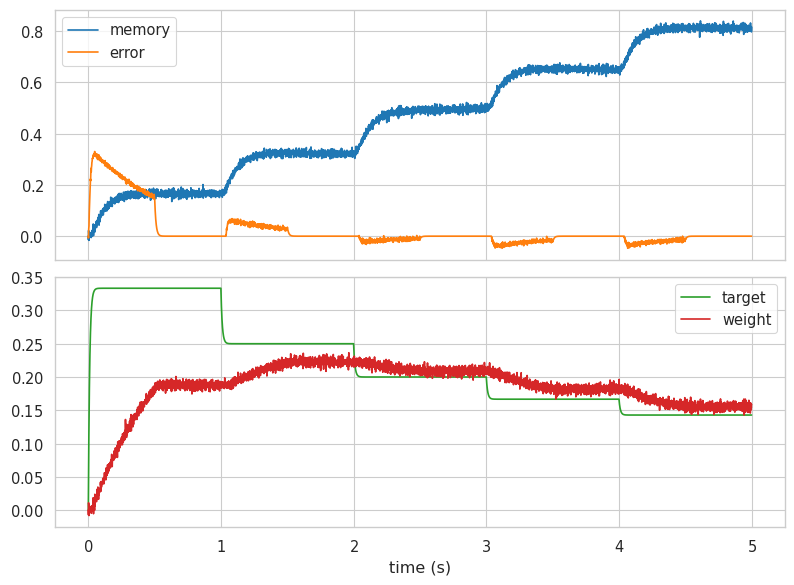

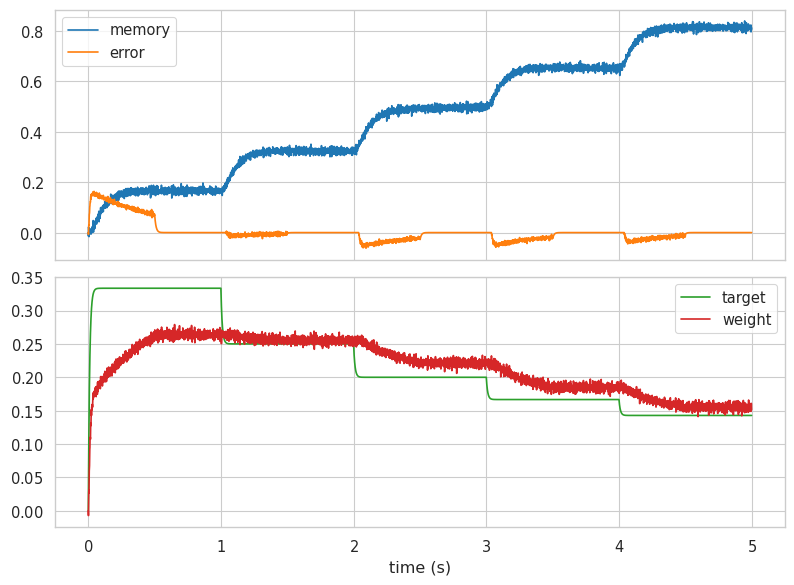

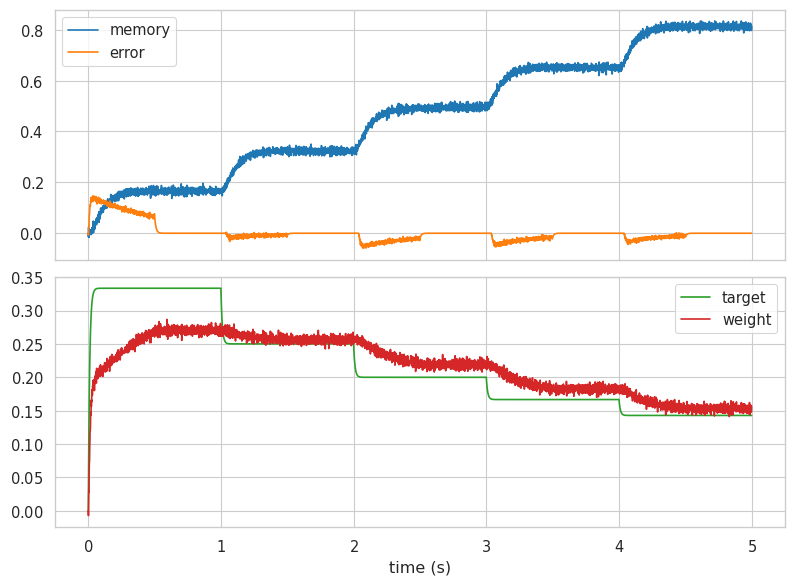

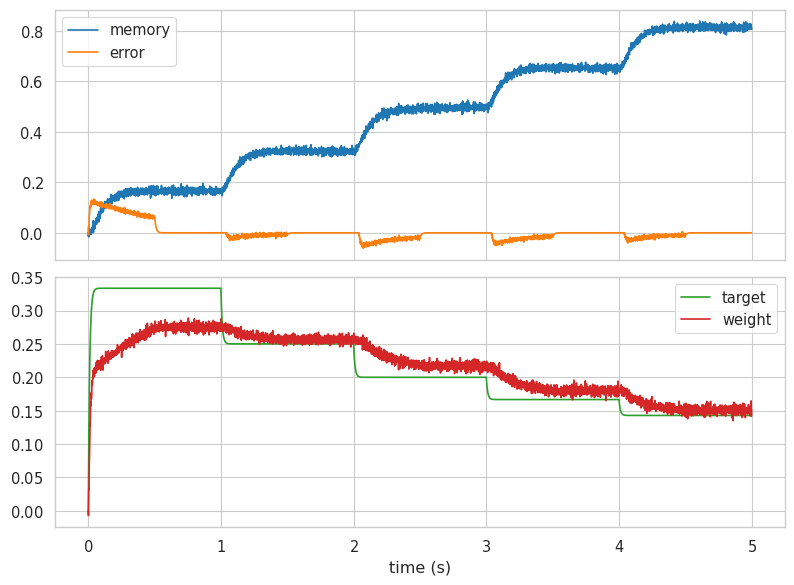

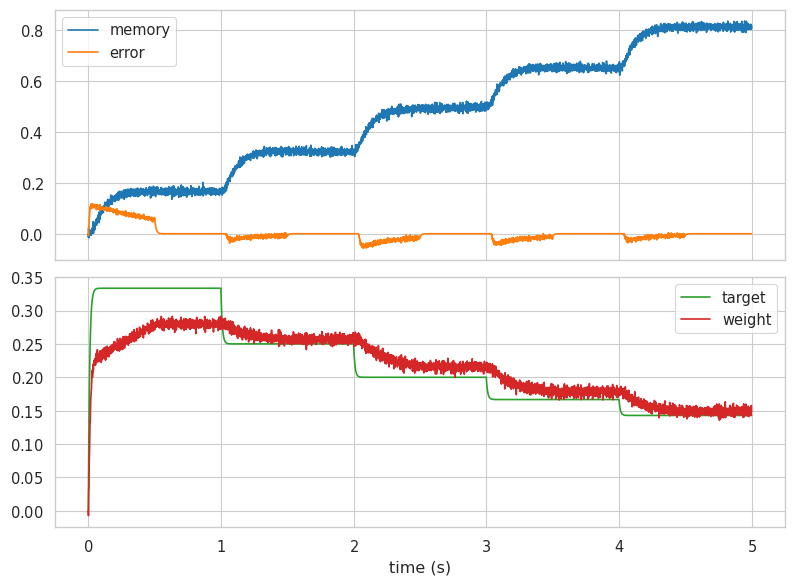

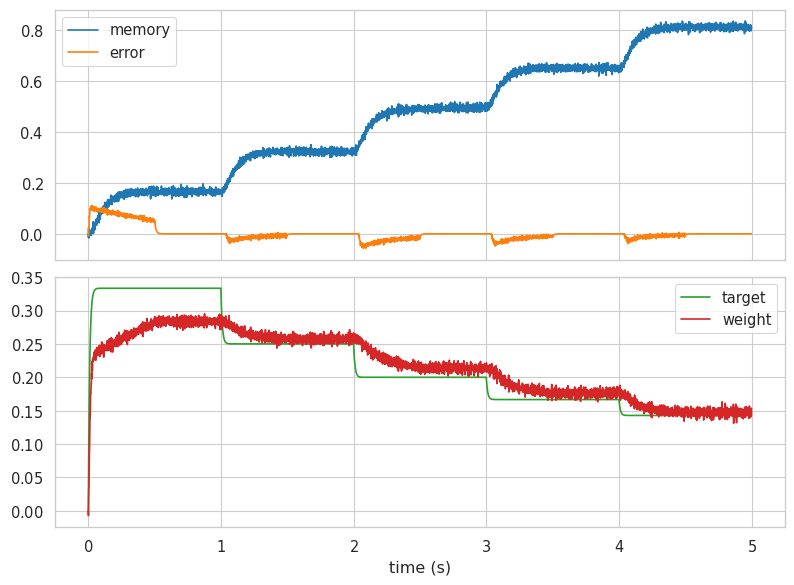

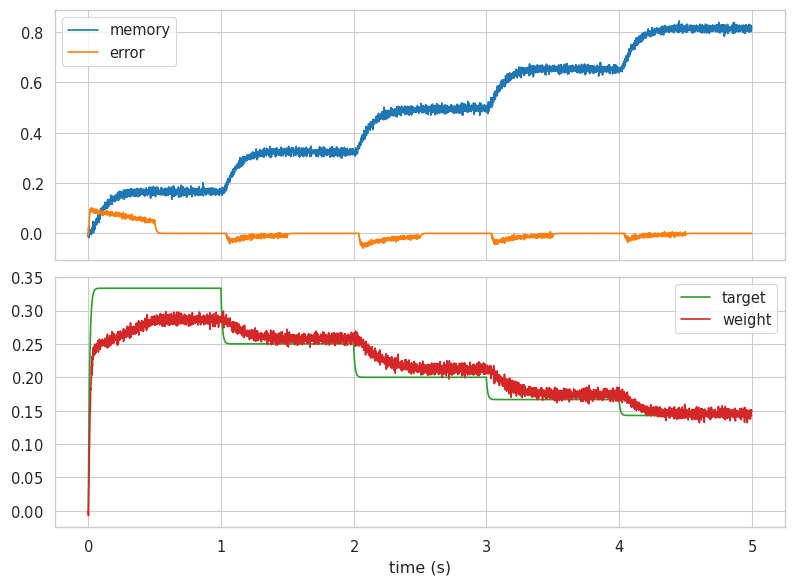

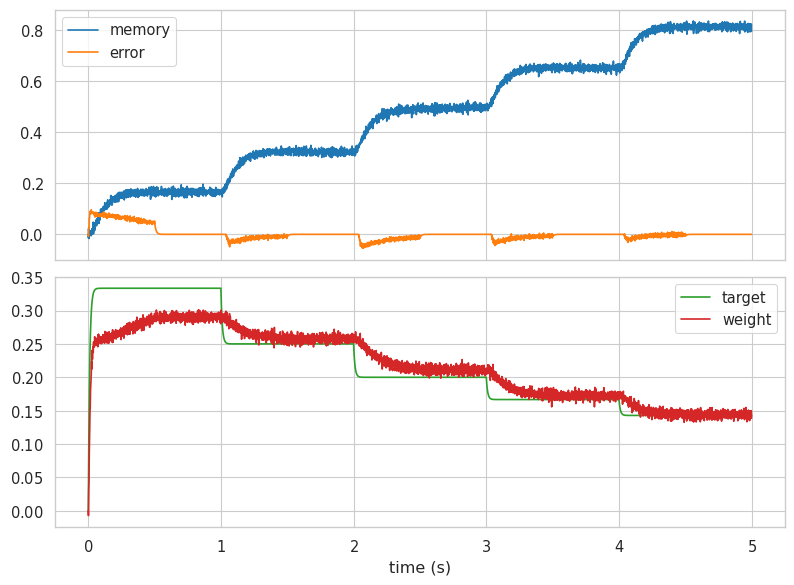

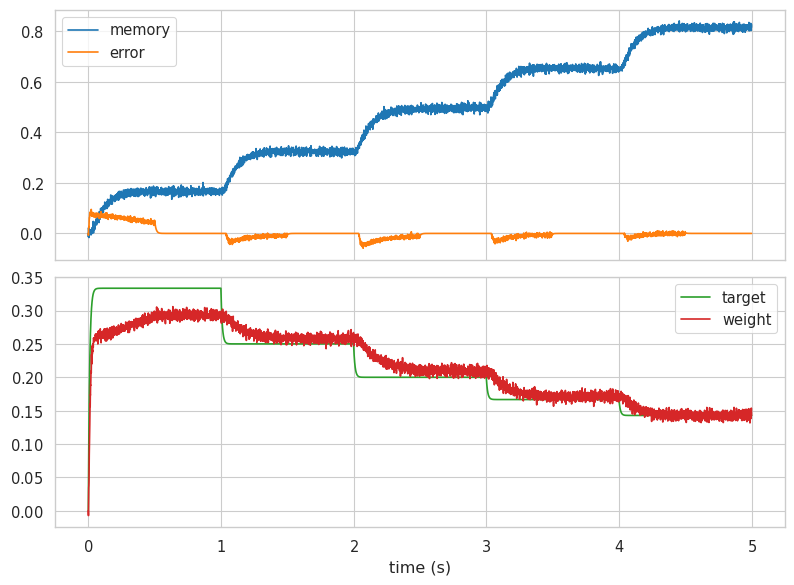

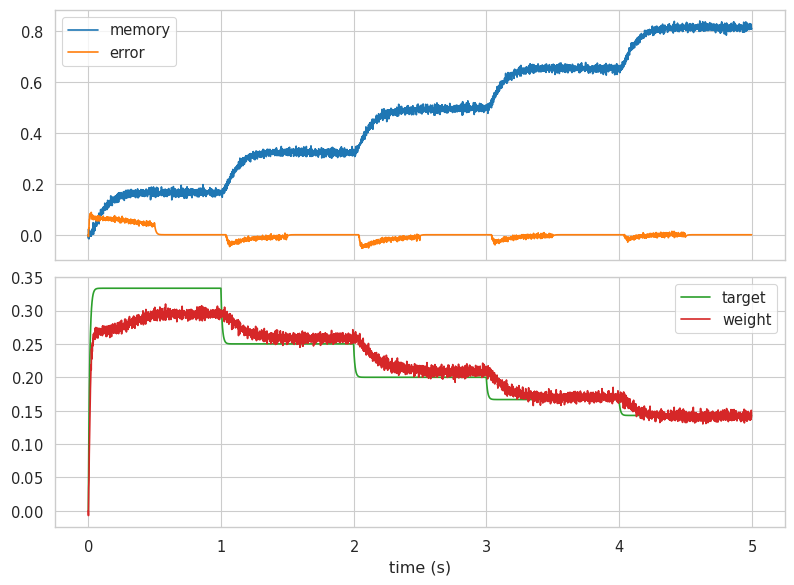

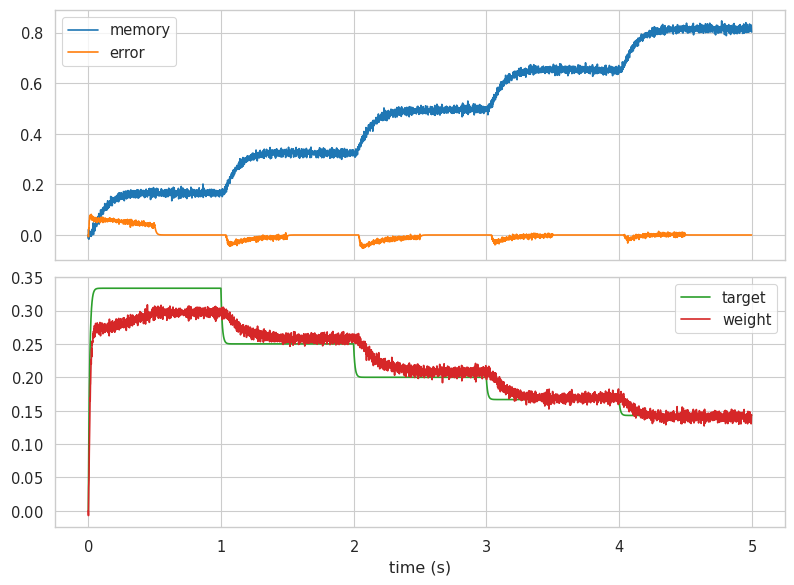

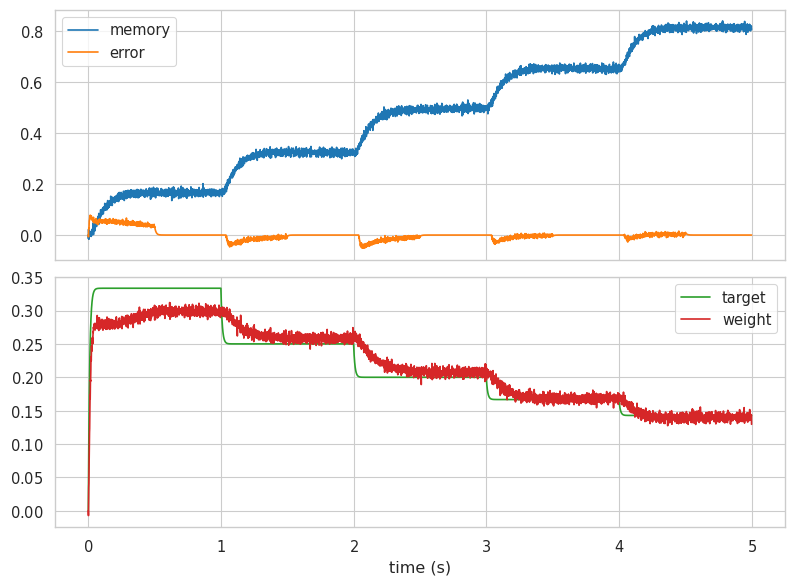

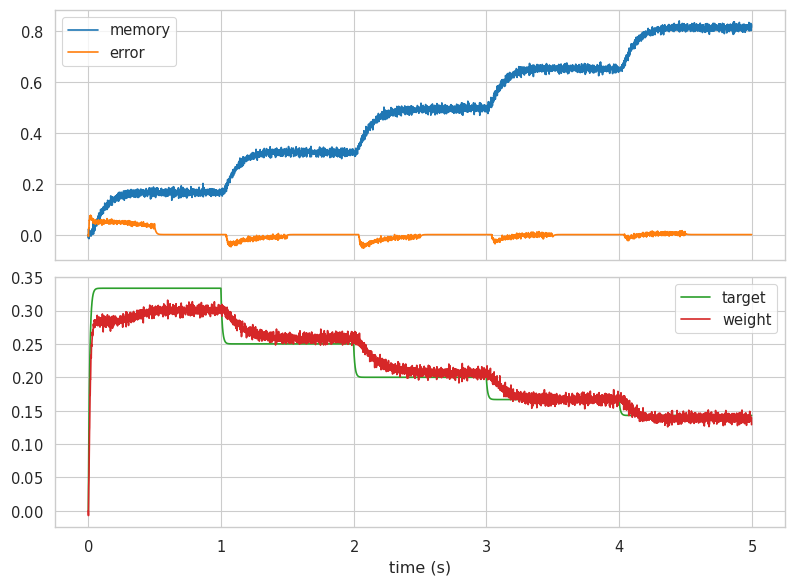

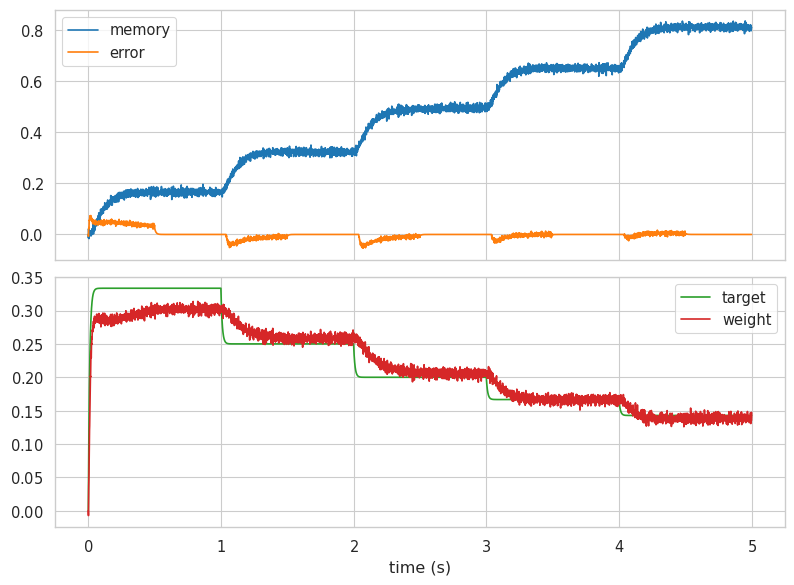

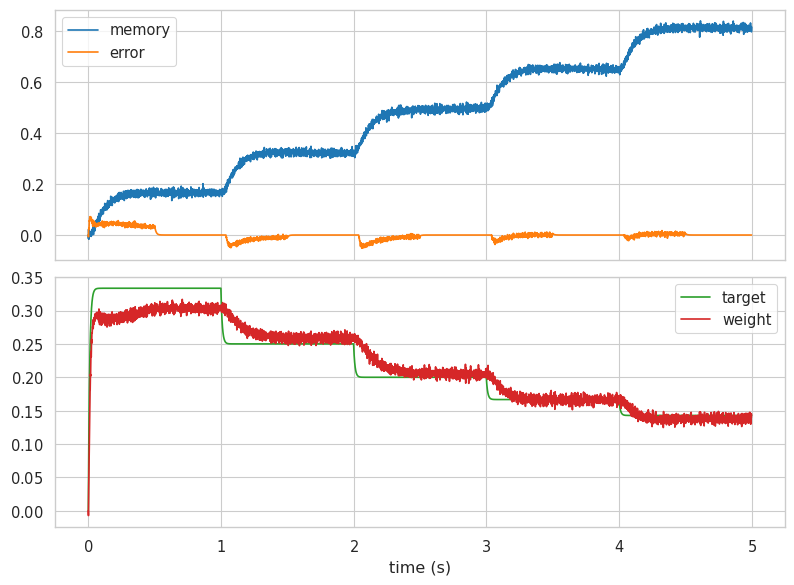

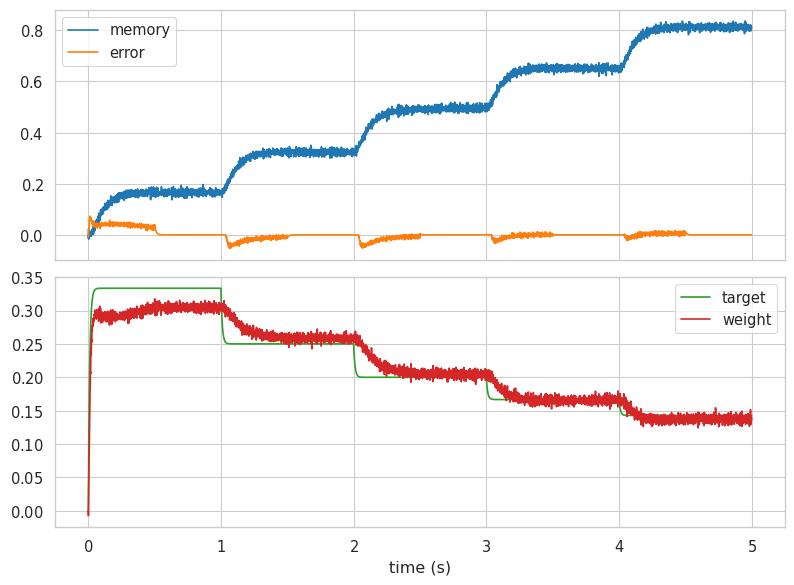

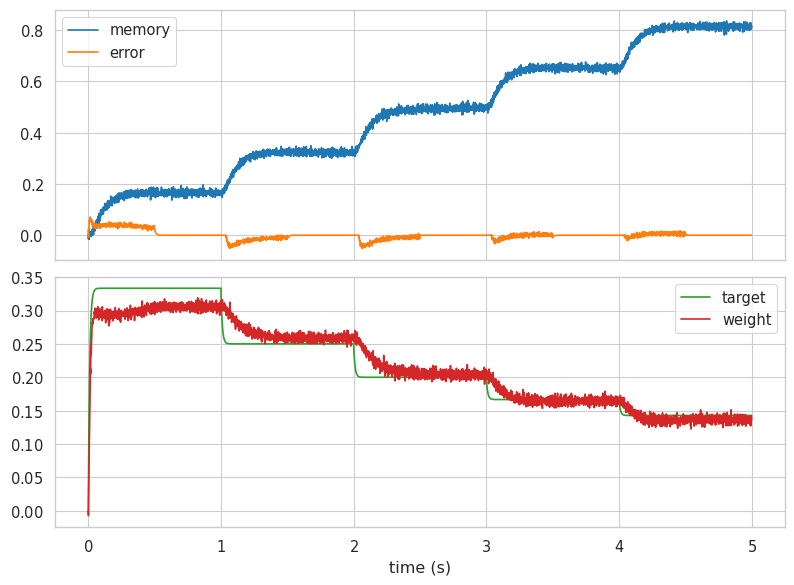

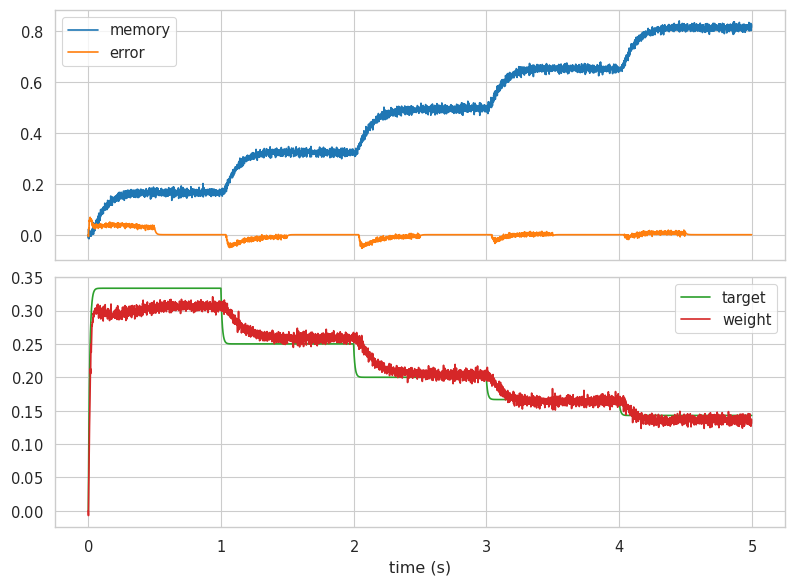

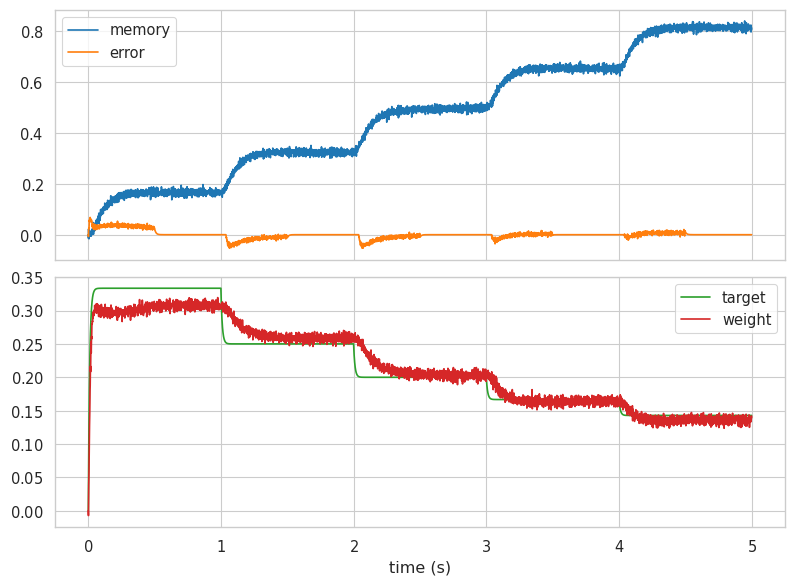

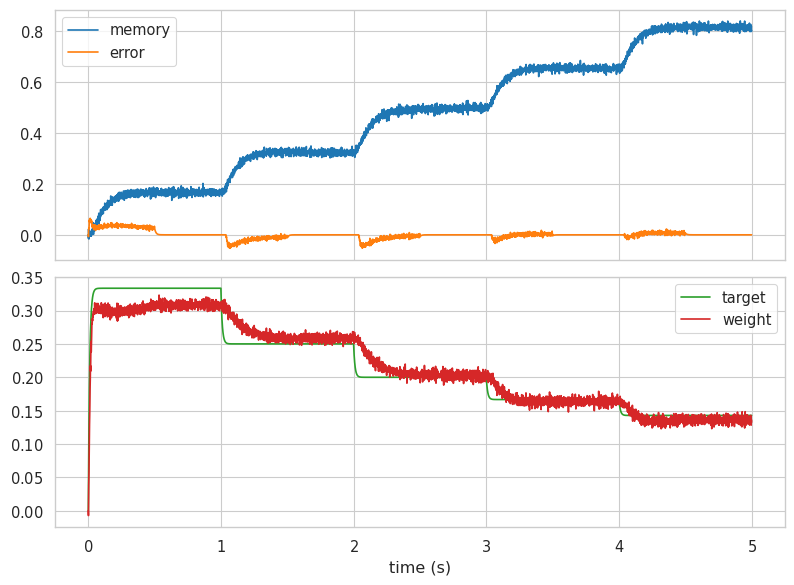

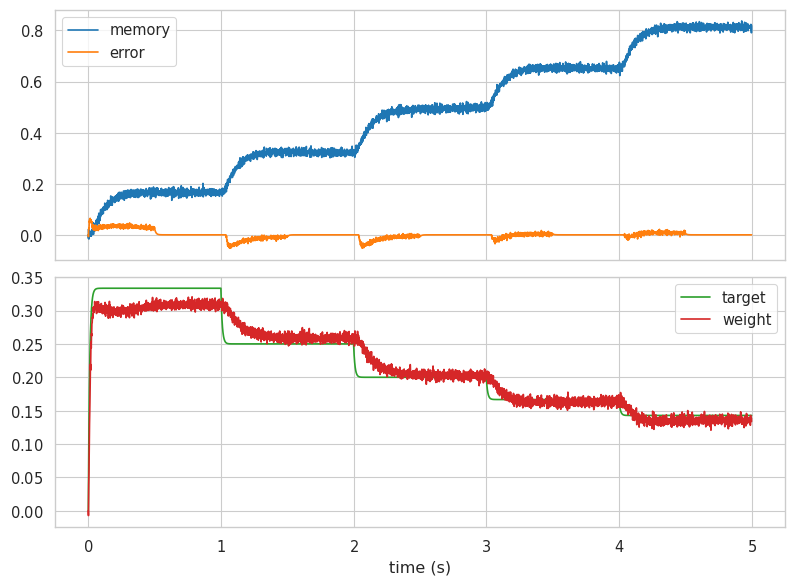

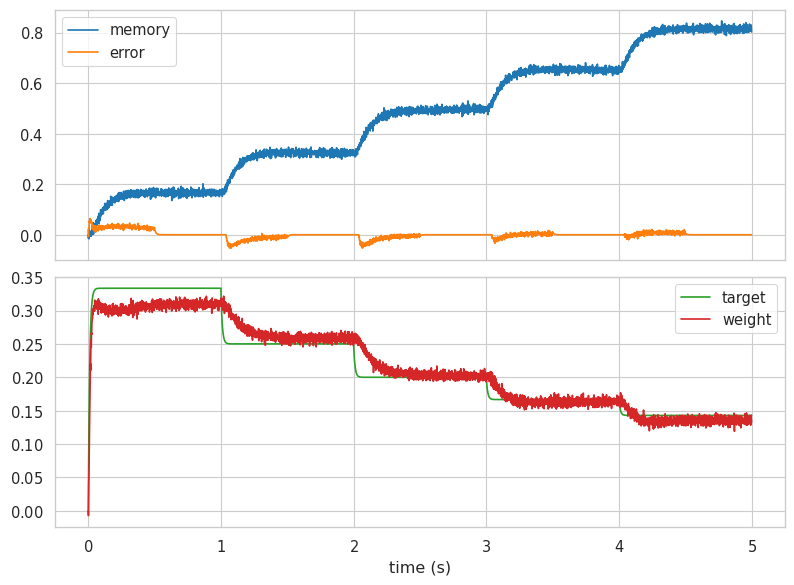

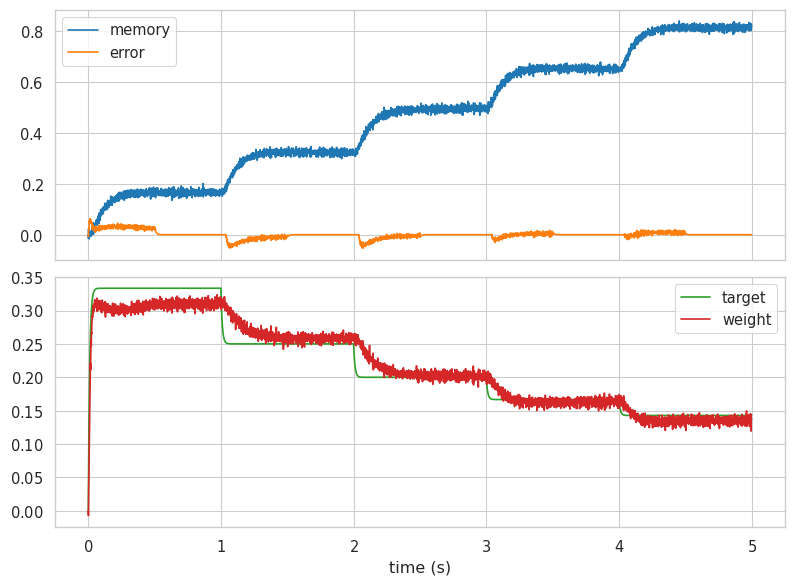

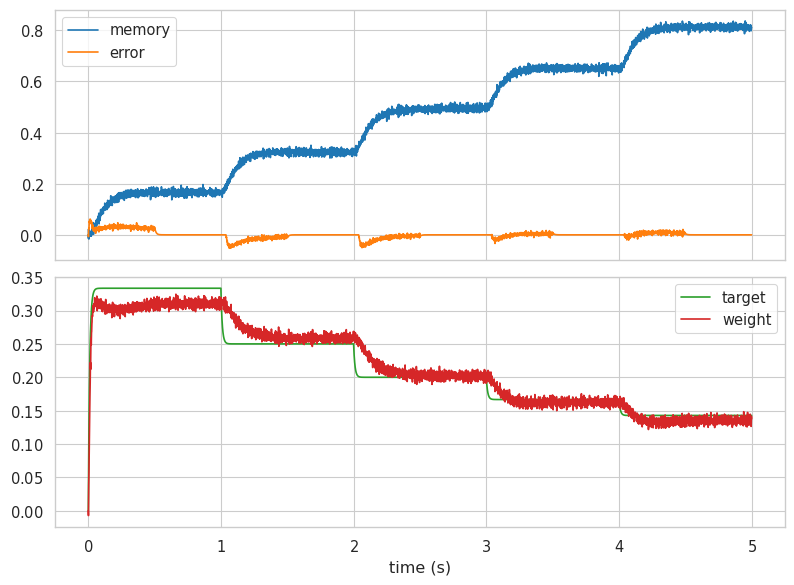

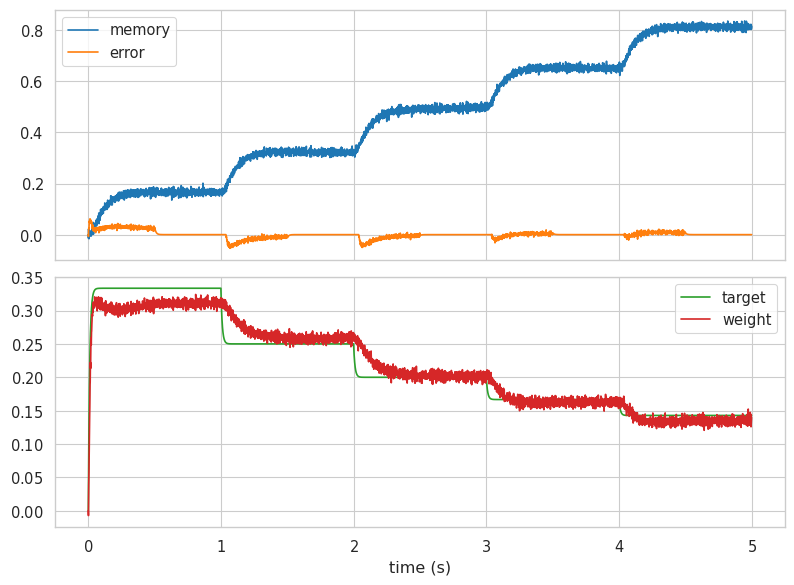

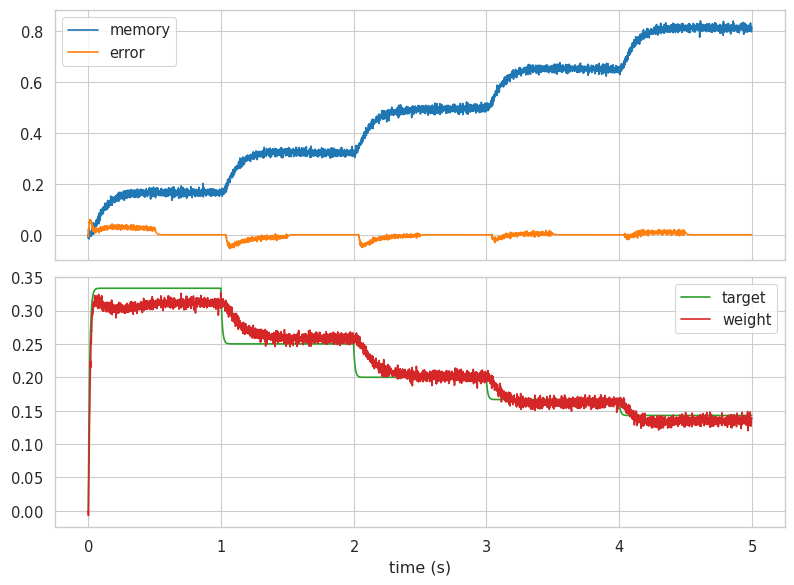

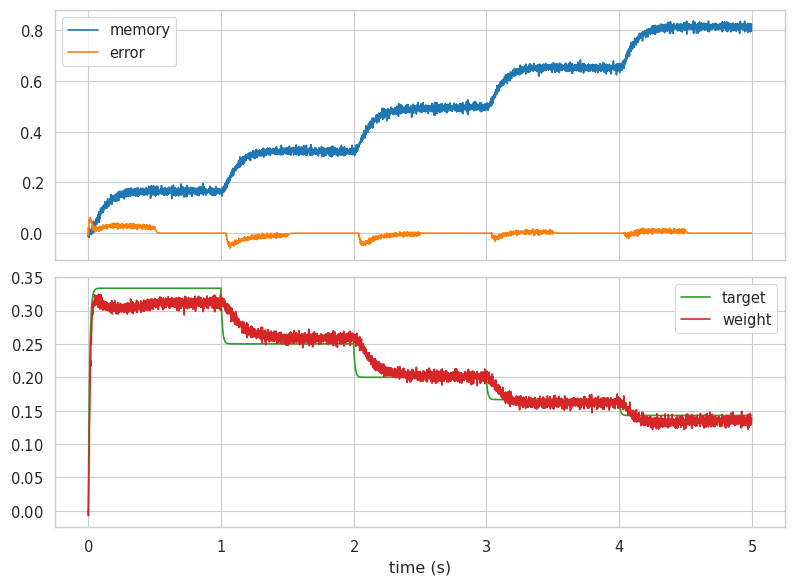

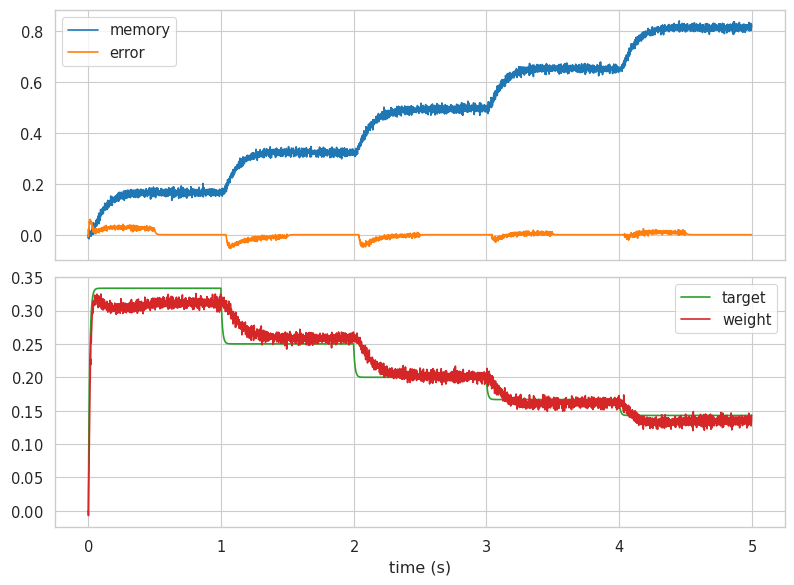

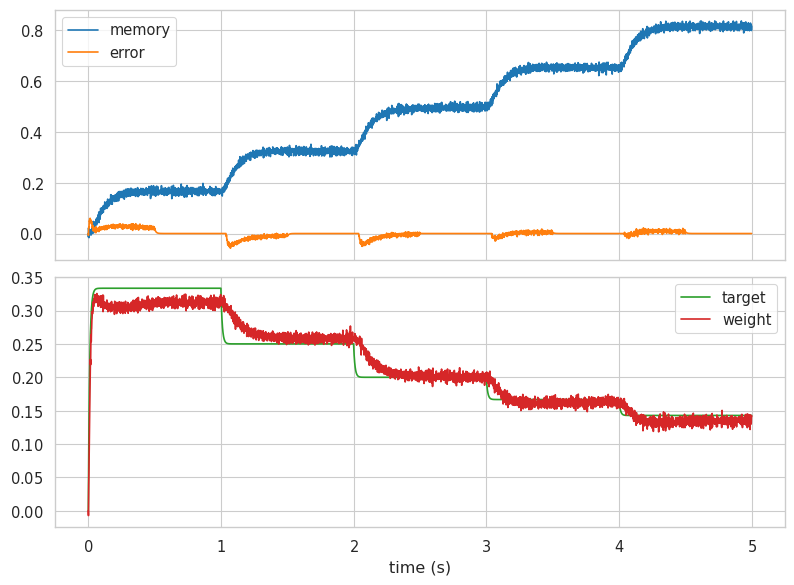

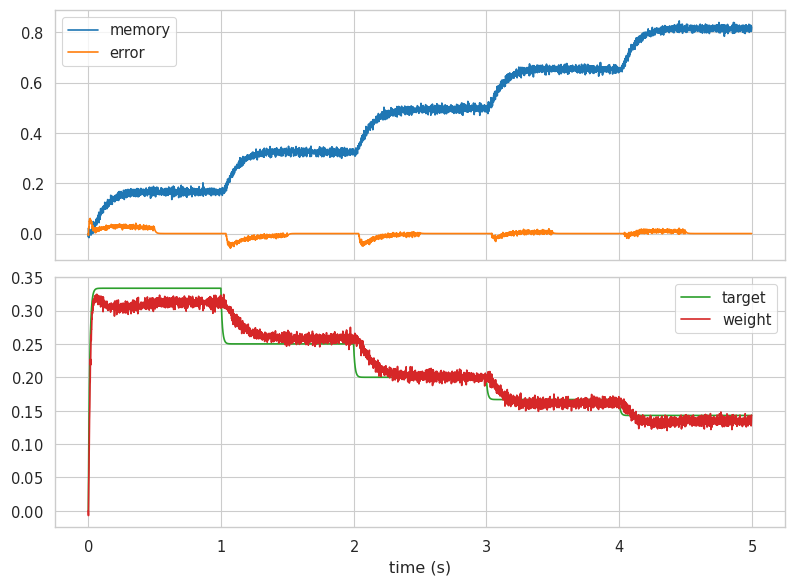

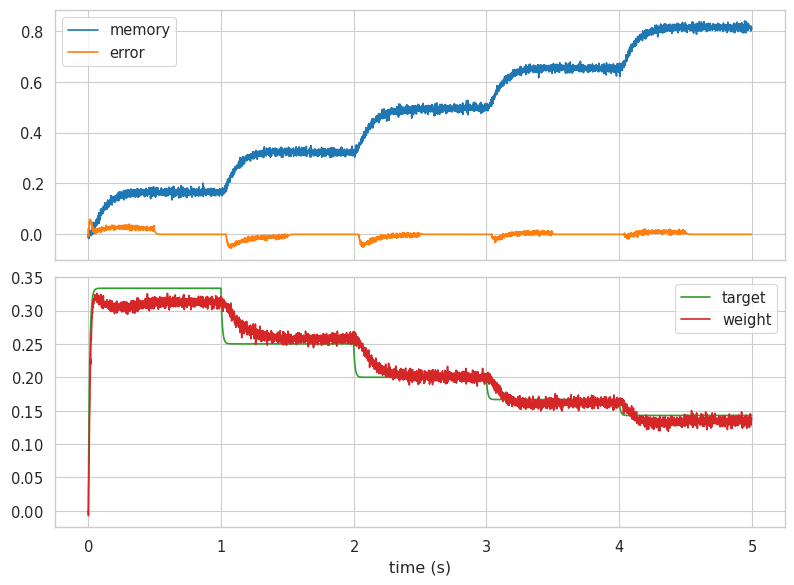

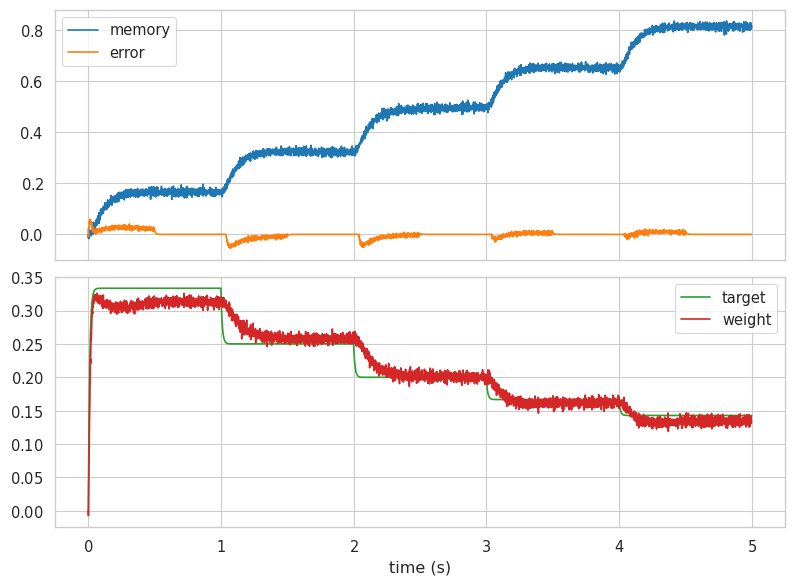

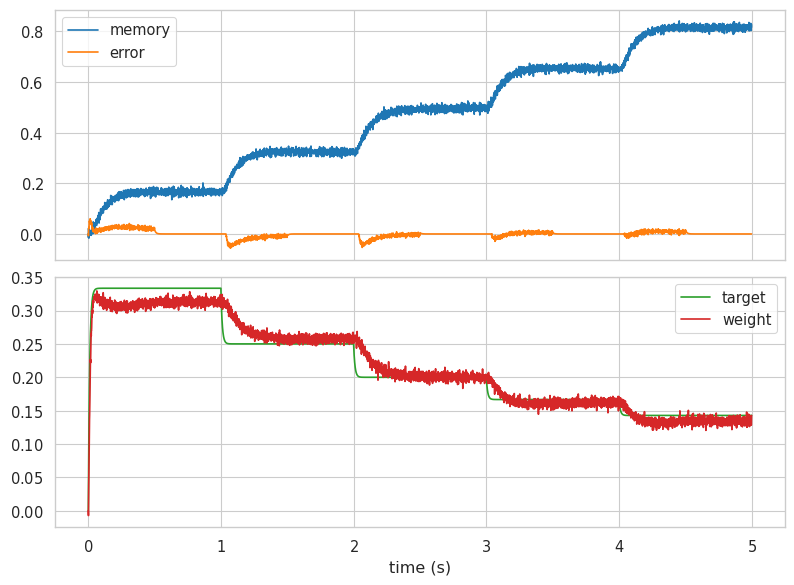

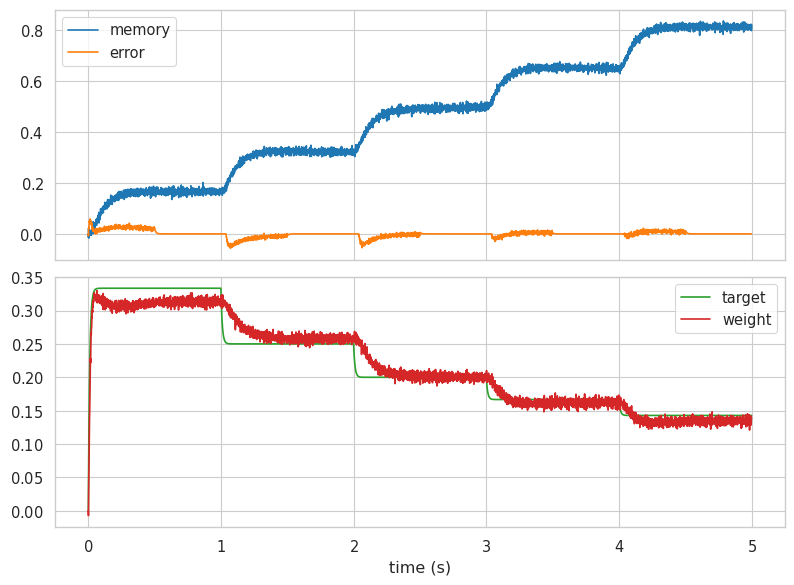

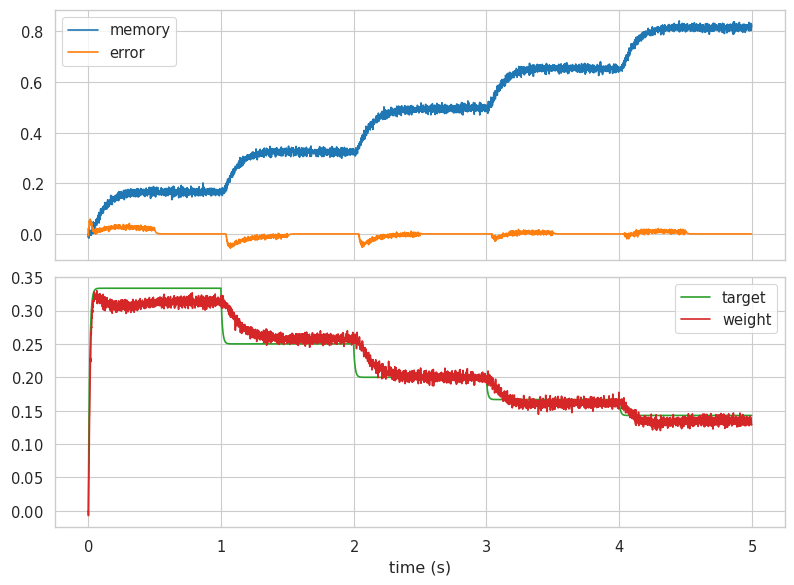

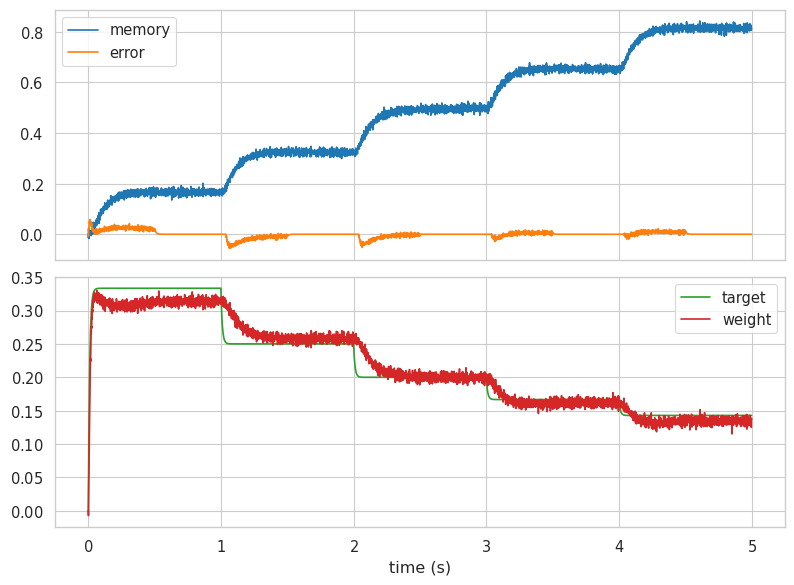

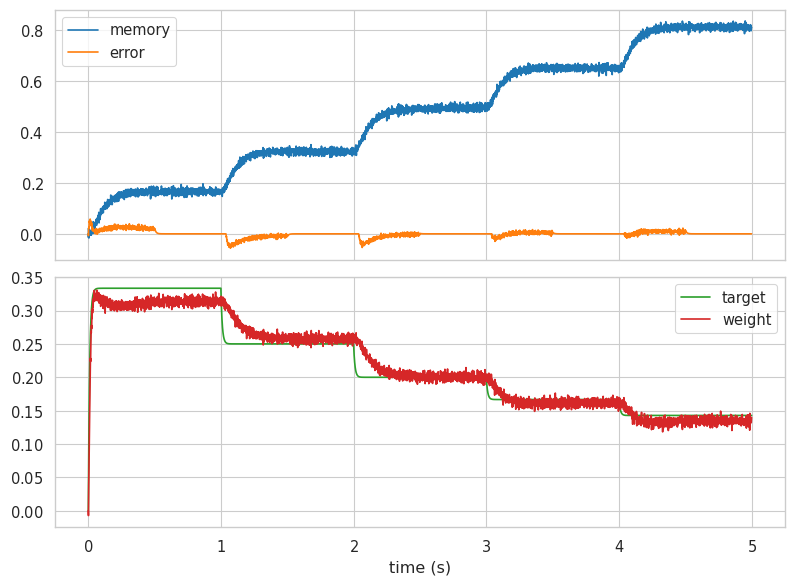

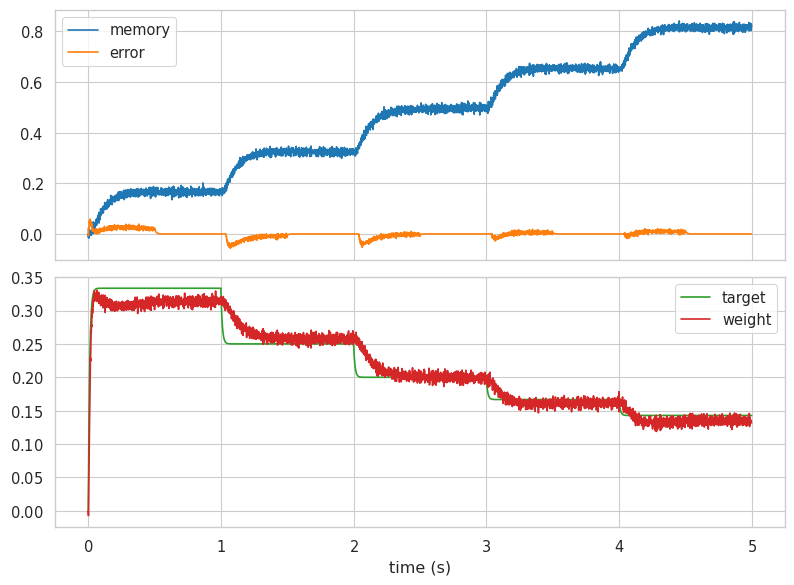

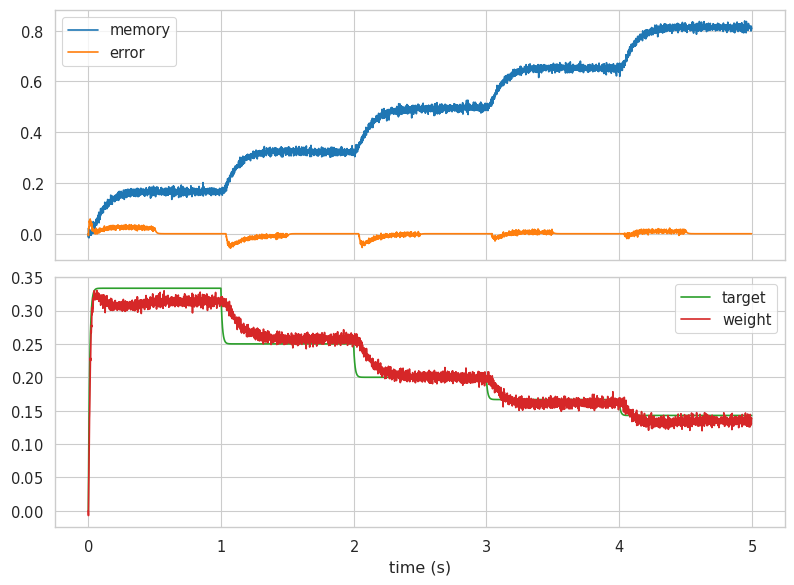

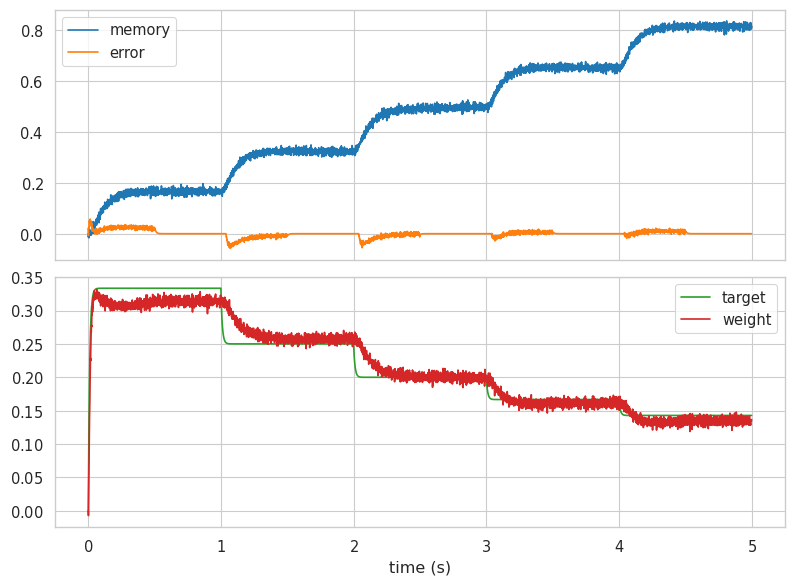

In [140]:
n_neurons = 1000
training_trials = 40
W = np.zeros((1, n_neurons))
for t in range(1, training_trials+1):
    print(f"training iteration {t}")
    env = EnvironmentRec('carrabin', sid=1, trial=t)
    W = pretrain(W, env, n_neurons=n_neurons, train=True)

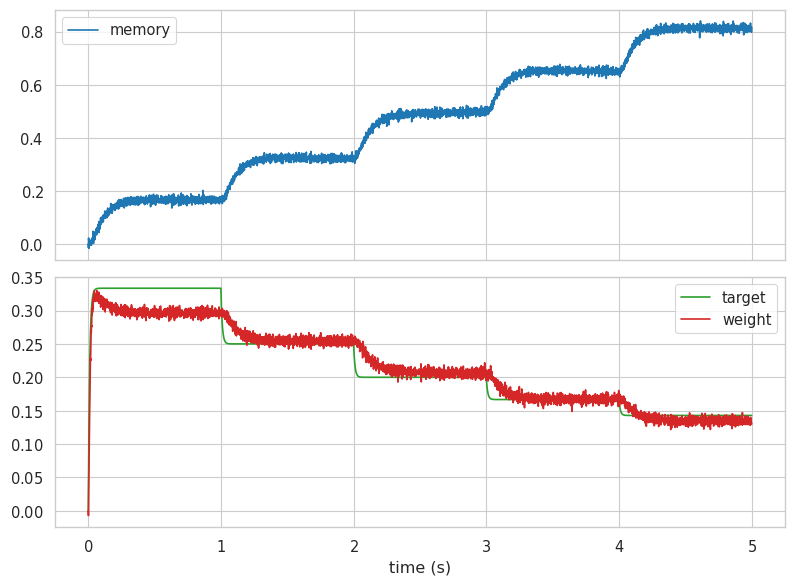

In [145]:
env = EnvironmentRec('carrabin', sid=1, trial=1)
net, sim = pretrain(W, env, n_neurons=n_neurons, train=False)

# Add in NEF_syn components

In [179]:
def build_network_syn(learned_weights, env, n_neurons=1000, seed_net=0, syn=0.01, syn_fb=0.2,
                      radius=1, a=1e-4, alpha=6e-5, dt=0.001, lambd=0, train=False):
    func_stim = lambda t: env.sample(t)
    func_context = lambda t: env.context
    func_weight = lambda t: np.power(int(t)+3, -lambd) if t!=-3 else 1
    func_stop = lambda t: 1 - np.abs(env.sample(t))

    w_inh_weight = -1000*np.ones((n_neurons, 1))
    w_inh_value = -1000*np.ones((int(n_neurons/2), 1))
    
    network = nengo.Network(seed=seed_net)
    with network:
        node_stim = nengo.Node(func_stim)
        node_target = nengo.Node(func_weight)
        node_stop = nengo.Node(func_stop)
        node_context = nengo.Node(func_context)
        
        stim = nengo.Ensemble(n_neurons, 1, seed=seed_net)
        delta = nengo.Ensemble(n_neurons, 1, encoders=nengo.dists.Choice([[1]]), intercepts=nengo.dists.Uniform(0,1), seed=seed_net)
        memory = nengo.Ensemble(n_neurons, 1, radius=radius, seed=seed_net)    
        weight = nengo.Ensemble(n_neurons, 1, seed=seed_net)
        context = nengo.Ensemble(n_neurons, env.dim_context, seed=seed_net)
        value = nengo.Ensemble(n_neurons, 1, seed=seed_net)
        if train:
            error_weight = nengo.Ensemble(n_neurons, 1, seed=seed_net)
        else:
            error_value = nengo.networks.Product(n_neurons, 1, seed=seed_net)

        nengo.Connection(node_stim, stim, seed=seed_net)
        nengo.Connection(node_context, context, seed=seed_net)
        nengo.Connection(stim, delta, synapse=syn, function=lambda x: 2*np.abs(x), seed=seed_net)
        nengo.Connection(stim, delta, synapse=0.1, function=lambda x: -2*np.abs(x), seed=seed_net)
        nengo.Connection(delta, memory, synapse=syn_fb, transform=syn_fb, seed=seed_net)
        nengo.Connection(memory, memory, synapse=syn_fb, seed=seed_net)
        if train:
            conn_weight = nengo.Connection(memory.neurons, weight, synapse=syn, seed=seed_net,
                                           transform=learned_weights, learning_rule_type=nengo.PES(learning_rate=a))
            nengo.Connection(node_target, error_weight, transform=1, seed=seed_net)
            nengo.Connection(weight, error_weight, transform=-1, seed=seed_net)
            nengo.Connection(error_weight, conn_weight.learning_rule, transform=-1, seed=seed_net)
            nengo.Connection(node_stop, error_weight.neurons, transform=w_inh_weight, seed=seed_net)
        else:
            conn_weight = nengo.Connection(memory.neurons, weight, transform=learned_weights, synapse=syn, seed=seed_net)
            conn_value = nengo.Connection(context, value, synapse=syn, seed=seed_net,
                                          learning_rule_type=nengo.PES(learning_rate=alpha), function=lambda x: 0)
            nengo.Connection(stim, error_value.input_a, synapse=syn)
            nengo.Connection(value, error_value.input_a, transform=-1, synapse=syn, seed=seed_net)
            nengo.Connection(weight, error_value.input_b, synapse=syn, seed=seed_net)
            nengo.Connection(error_value.output, conn_value.learning_rule, synapse=syn, transform=-1, seed=seed_net)
            nengo.Connection(node_stop, error_value.sq1.ea_ensembles[0].neurons, transform=w_inh_value, seed=seed_net)
            nengo.Connection(node_stop, error_value.sq2.ea_ensembles[0].neurons, transform=w_inh_value, seed=seed_net)

        probe_stim = nengo.Probe(stim, synapse=syn)
        probe_target = nengo.Probe(node_target, synapse=syn)
        probe_delta = nengo.Probe(delta, synapse=syn)
        probe_memory = nengo.Probe(memory, synapse=syn)
        probe_weight = nengo.Probe(weight, synapse=syn)
        probe_value = nengo.Probe(value, synapse=syn)
        if train:
            probe_error_weight = nengo.Probe(error_weight, synapse=0.01)
            probe_learned_weights = nengo.Probe(conn_weight, "weights")
        else:
            probe_error_value = nengo.Probe(error_value.output, synapse=0.01)
            

    sim = nengo.Simulator(network, dt=dt, progress_bar=False)
    with sim:
        sim.run(5-dt)

    if train:
        learned_weights = sim.data[probe_learned_weights][-1]
        with sns.axes_style("whitegrid"):  # This enables gridlines
            fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(8,6))
            # sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_stim].flatten(), label='observations', color=palette[0], ax=axes[0])
            sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_memory].flatten(), label='memory', color=palette[0], ax=axes[0])
            sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_error_weight].flatten(), label='error', color=palette[1], ax=axes[0])
            sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_target].flatten(), label='target', color=palette[2], ax=axes[1])
            sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_weight].flatten(), label='weight', color=palette[3], ax=axes[1])
            # axes[0].set(title=f"training iteration {seed_stim}")
            axes[1].set(xlabel='time (s)')
            plt.grid(True, axis='y')  # Enable only y-axis gridlines
            fig.tight_layout()
            plt.show()
            plt.close('all')
    else:
        with sns.axes_style("whitegrid"):  # This enables gridlines
            fig, axes = plt.subplots(nrows=1, sharex=True, figsize=(8,3))
            sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_stim].flatten(), label='observations', color=palette[0], ax=axes)
            sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_value].flatten(), label='value', color=palette[1], ax=axes)
            sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_error_value].flatten(), label='error', color=palette[2], ax=axes)
            axes.set(xlabel='time (s)')
            plt.grid(True, axis='y')  # Enable only y-axis gridlines
            fig.tight_layout()
    if train:
        return learned_weights
    else:
        return network, sim

training iteration 1
training iteration 2
training iteration 3
training iteration 4
training iteration 5
training iteration 6
training iteration 7
training iteration 8
training iteration 9
training iteration 10
training iteration 11
training iteration 12
training iteration 13
training iteration 14
training iteration 15
training iteration 16
training iteration 17
training iteration 18
training iteration 19
training iteration 20
training iteration 21


/tmp/ipykernel_360461/507244038.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(8,6))


training iteration 22
training iteration 23
training iteration 24
training iteration 25
training iteration 26
training iteration 27
training iteration 28
training iteration 29
training iteration 30
training iteration 31
training iteration 32
training iteration 33
training iteration 34
training iteration 35
training iteration 36
training iteration 37
training iteration 38
training iteration 39
training iteration 40


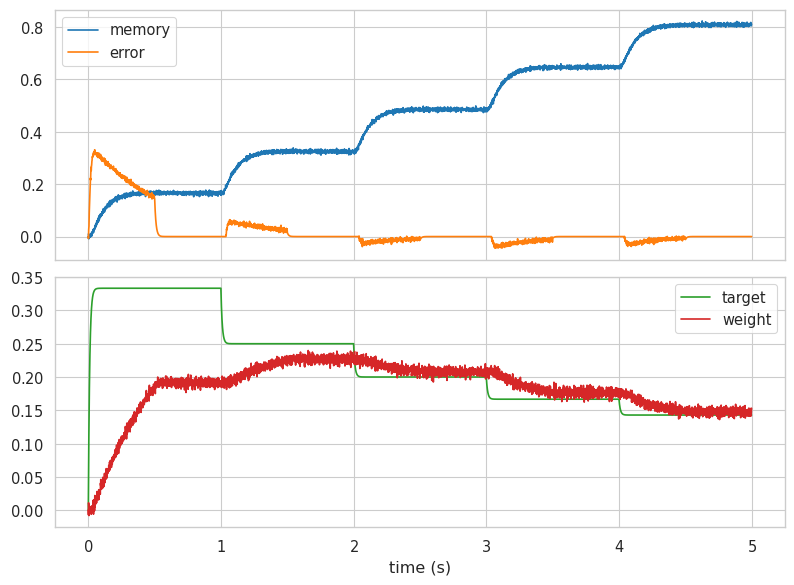

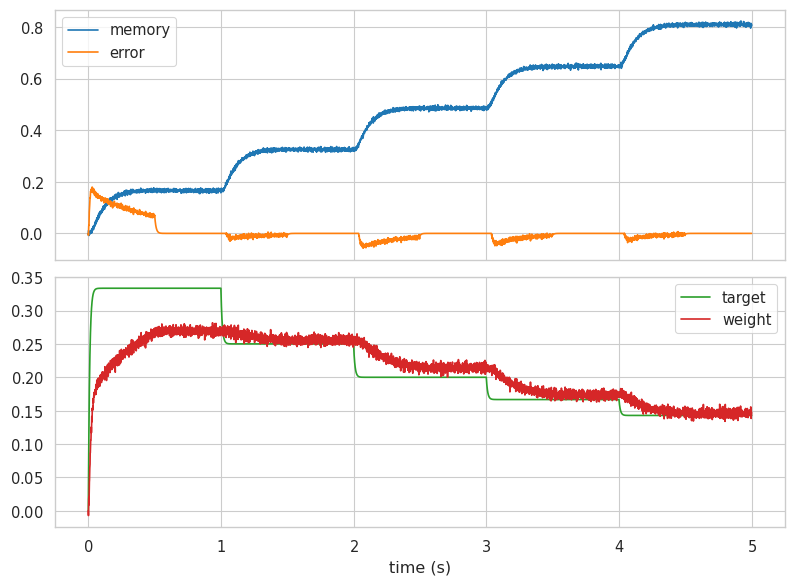

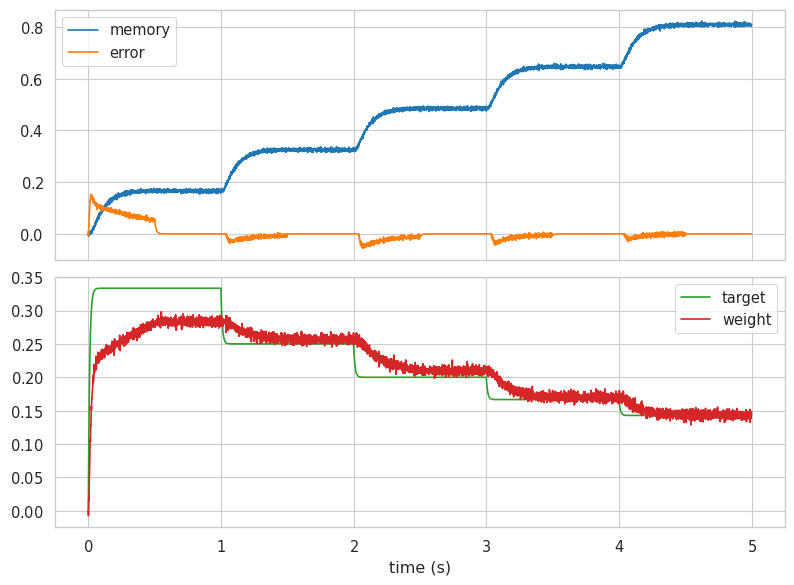

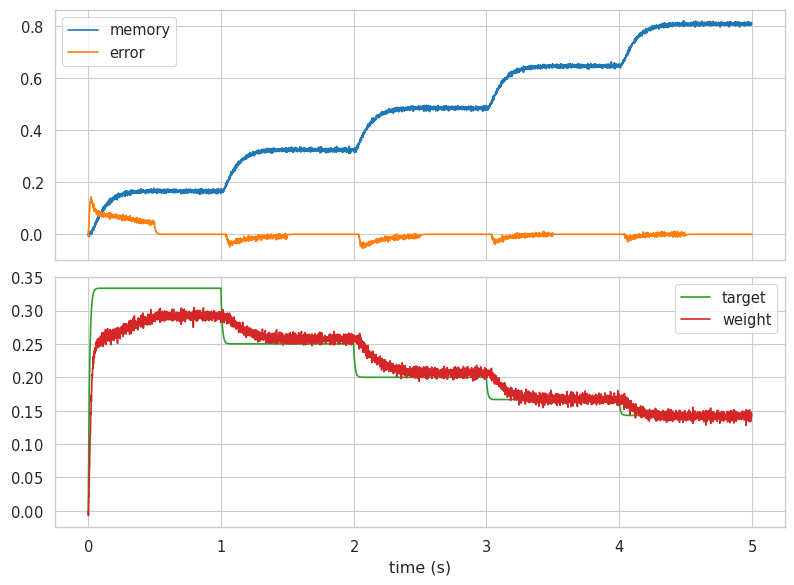

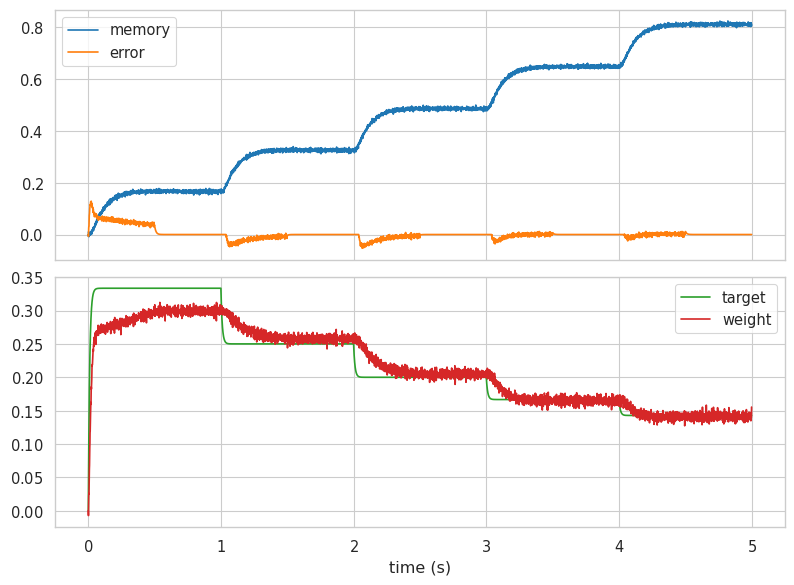

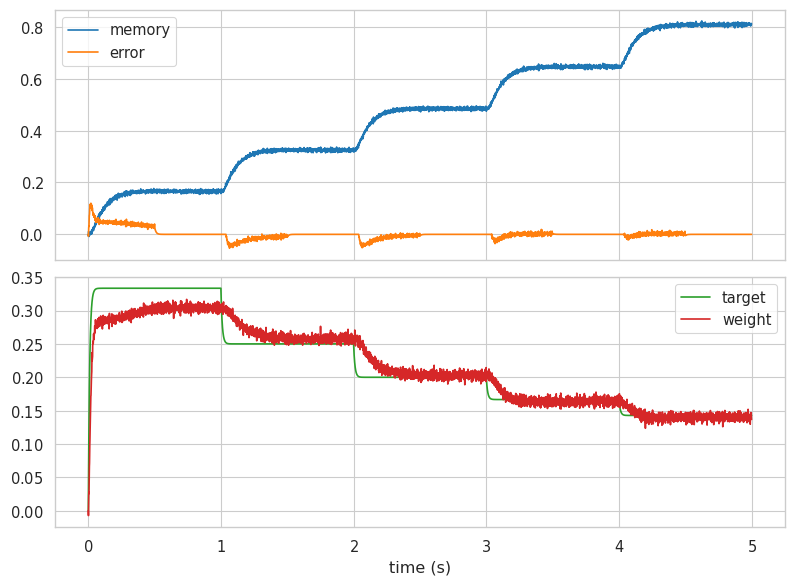

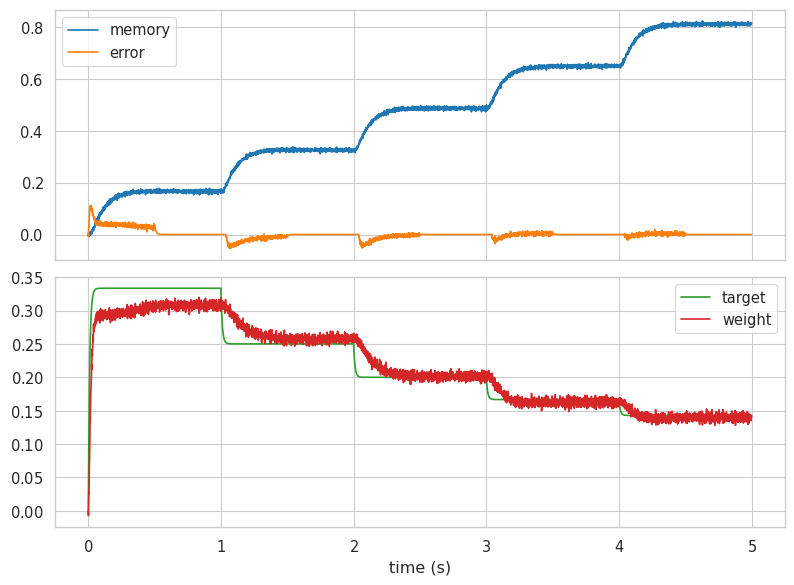

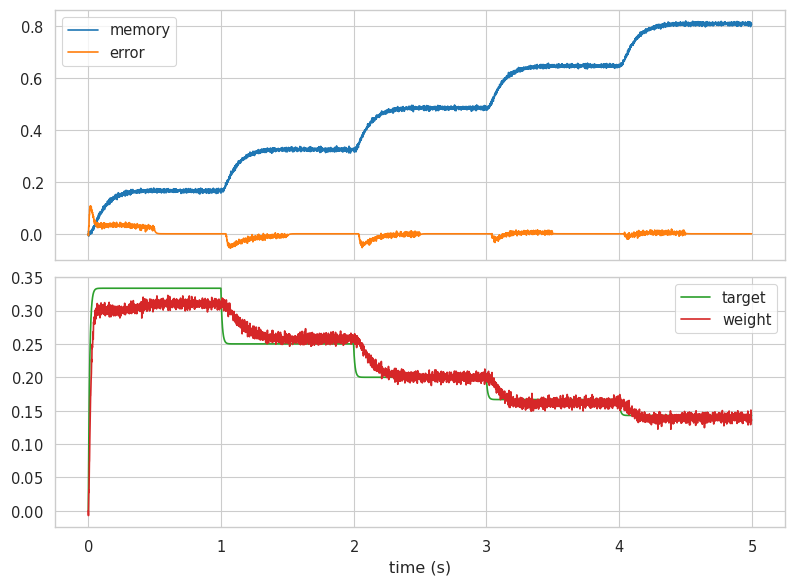

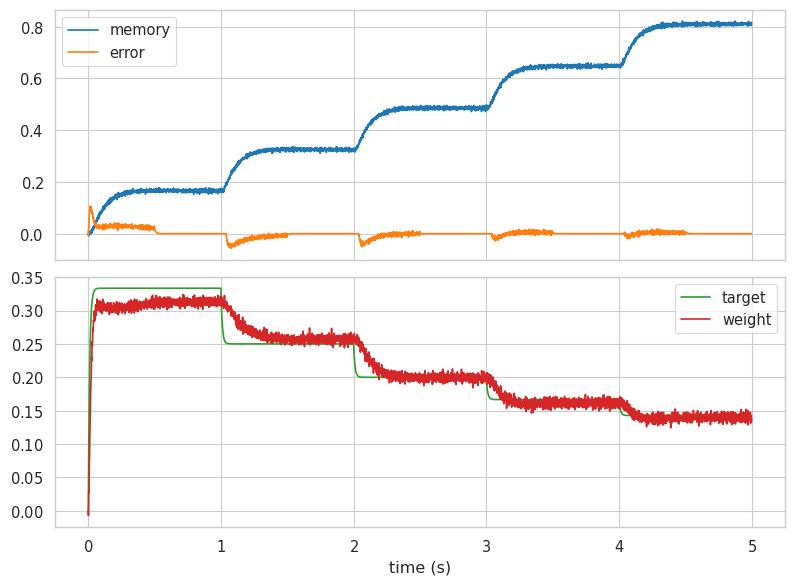

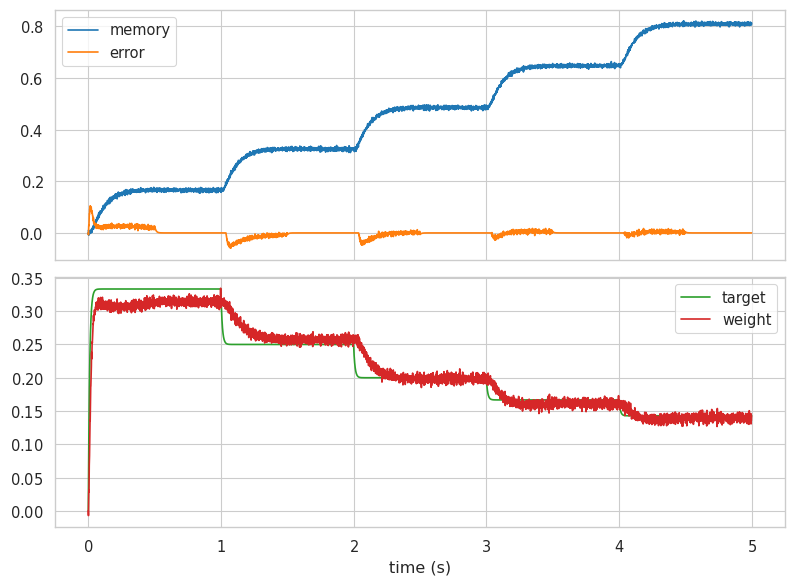

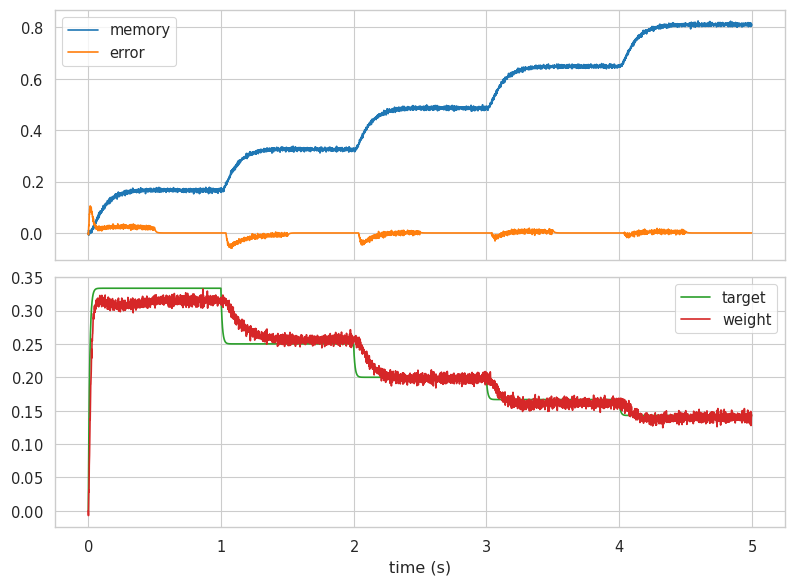

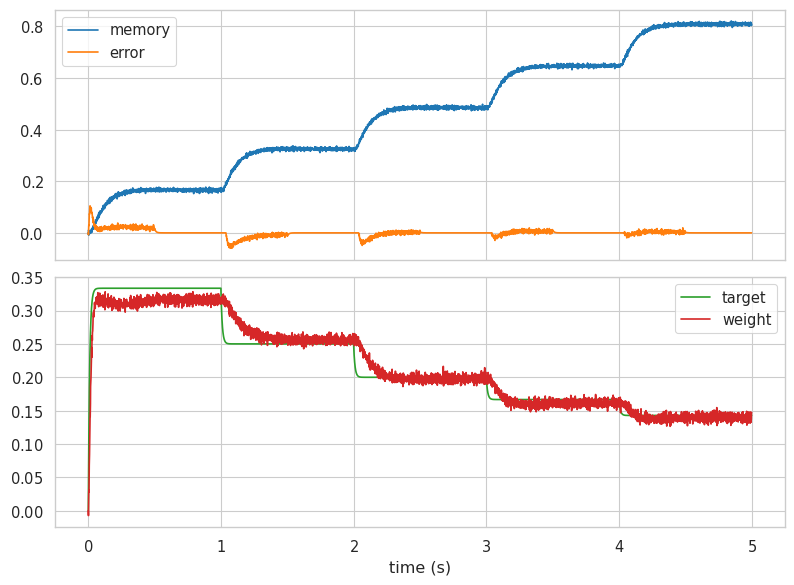

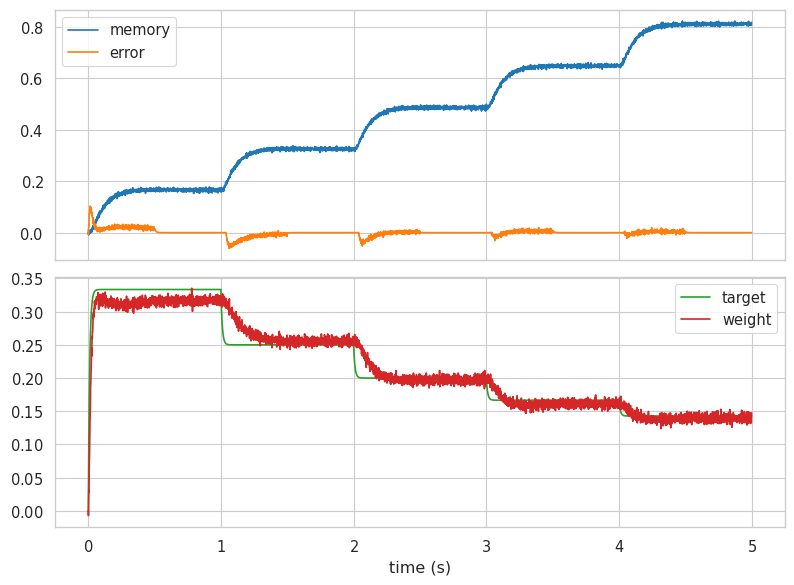

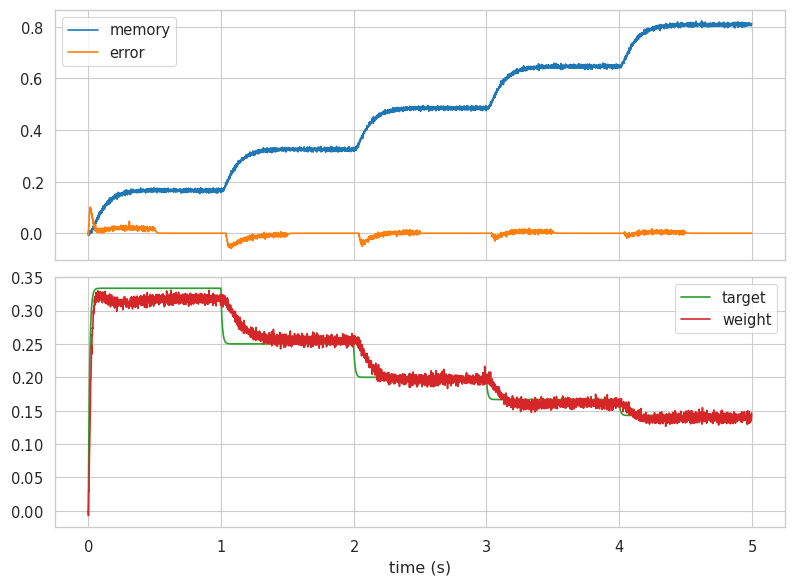

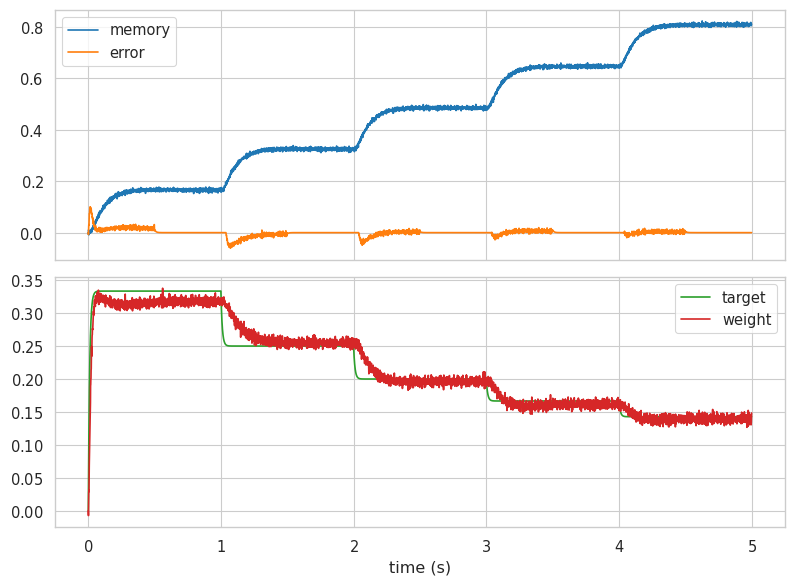

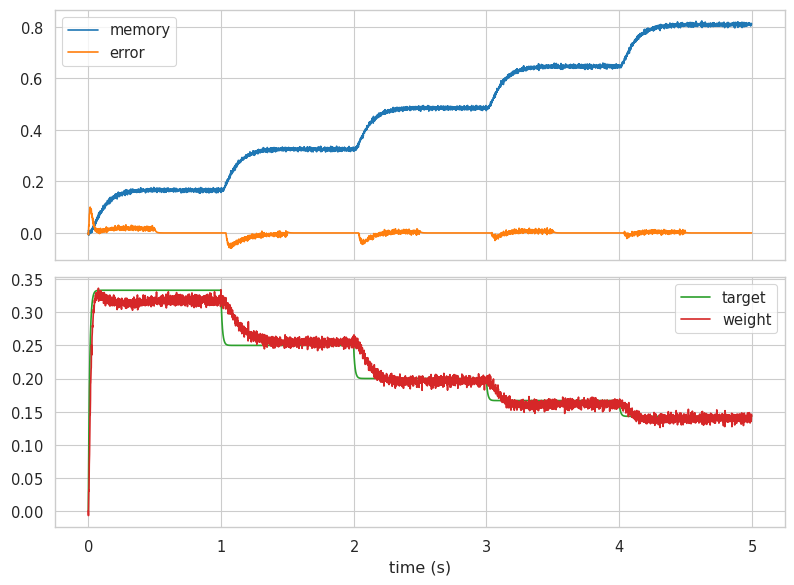

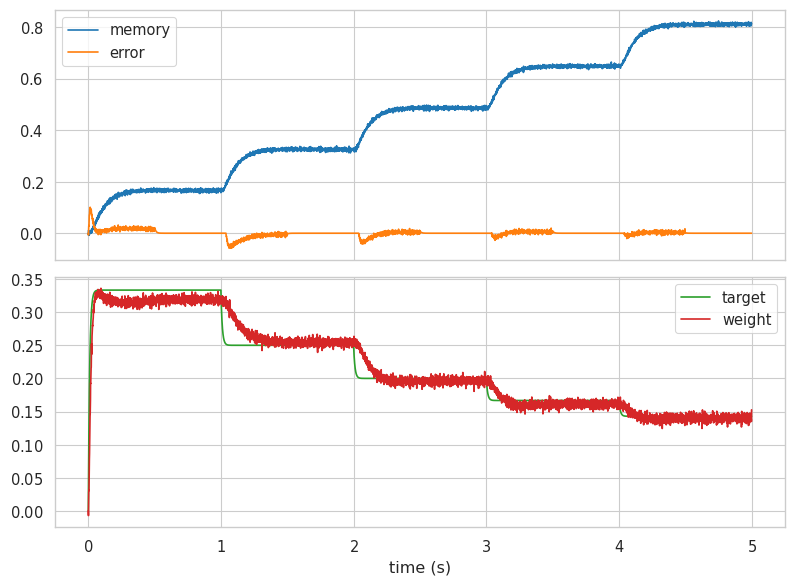

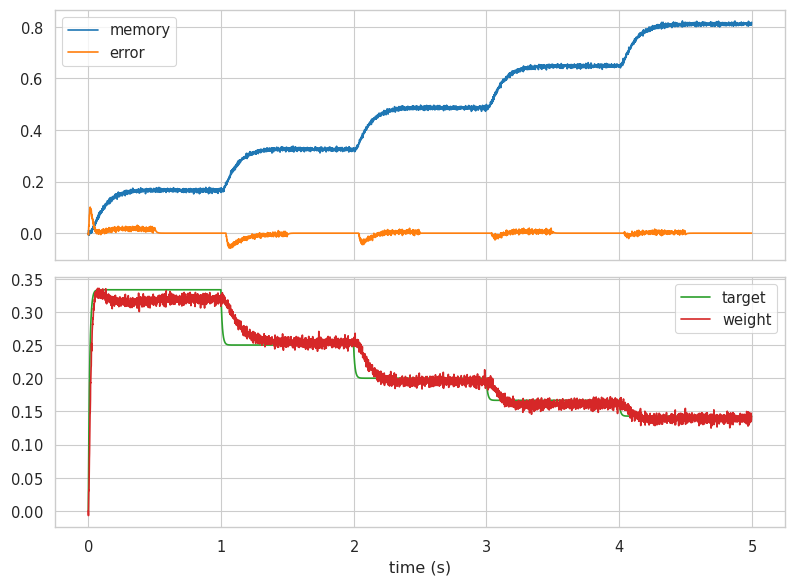

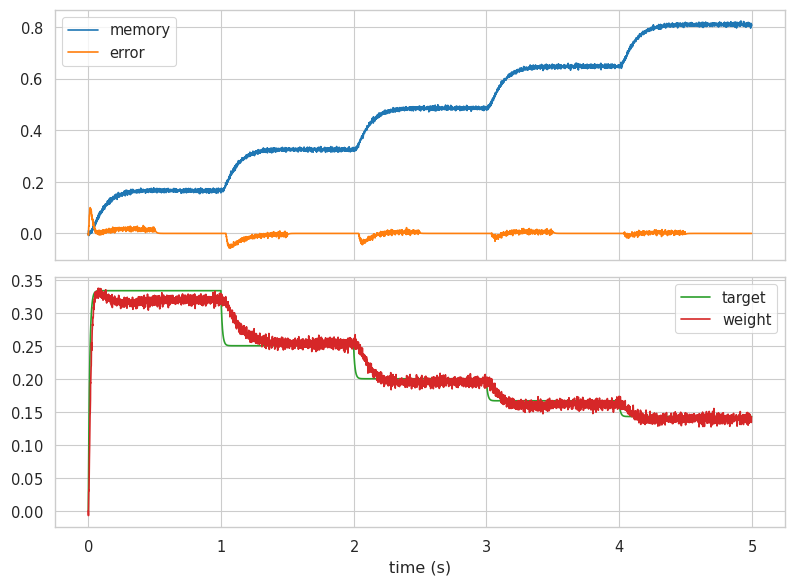

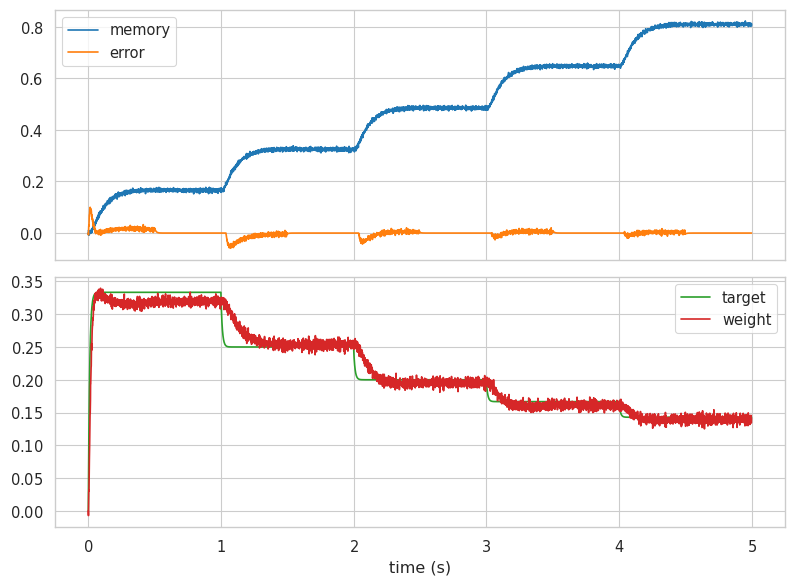

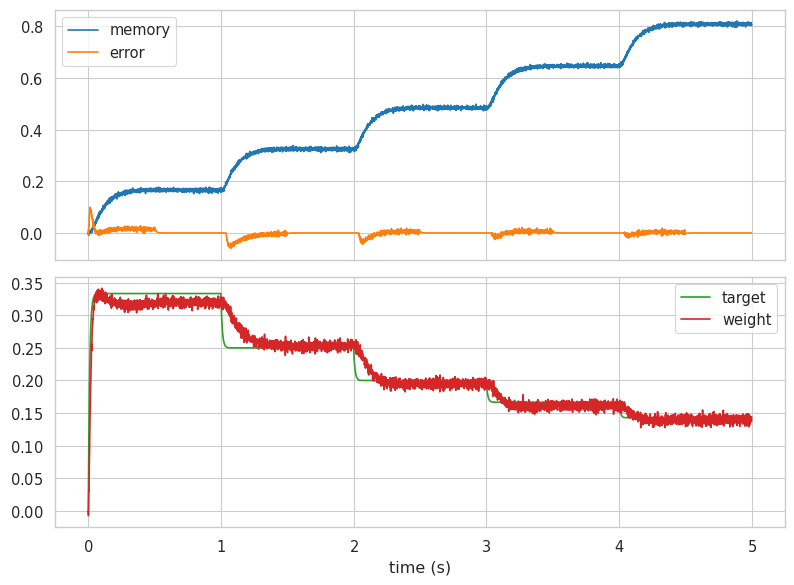

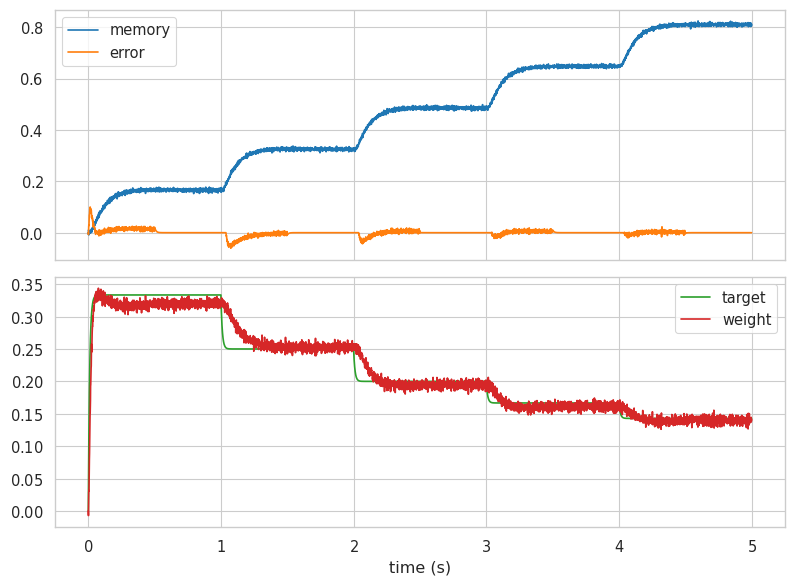

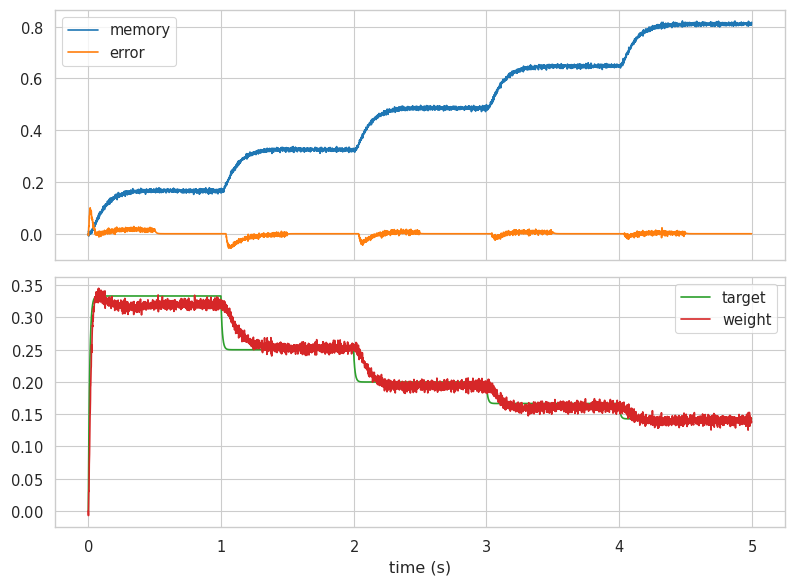

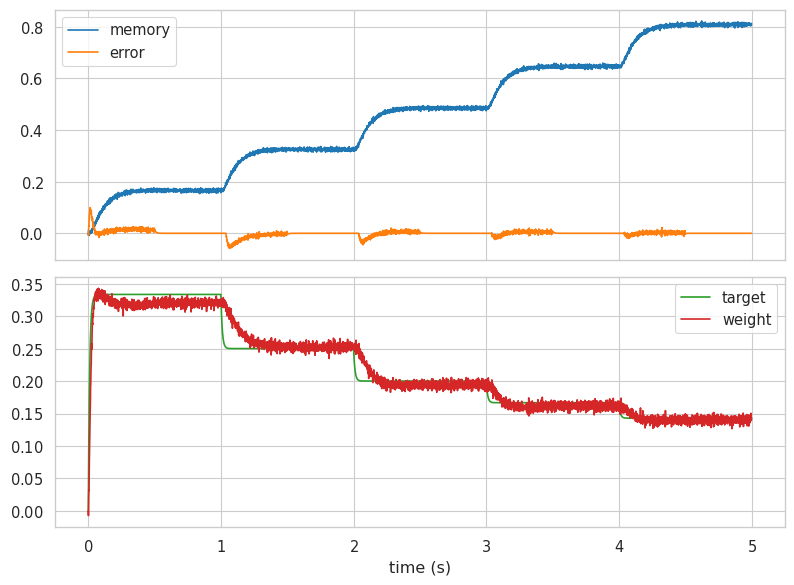

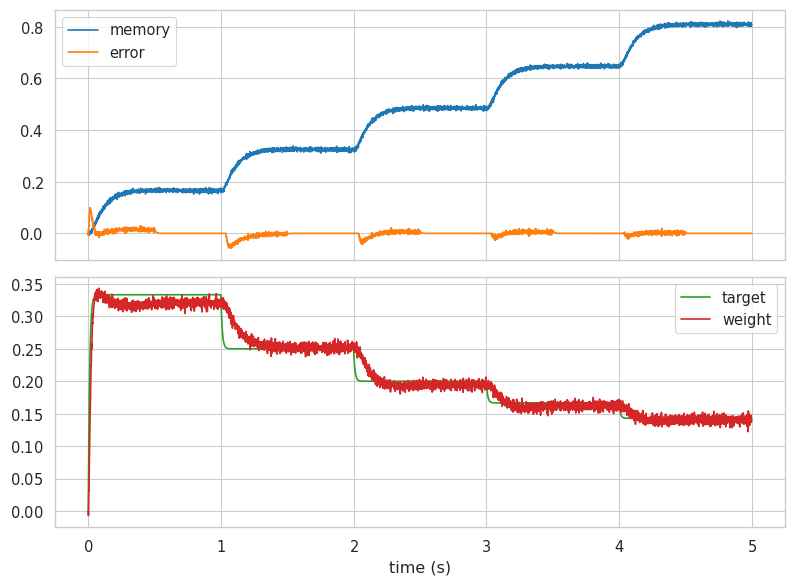

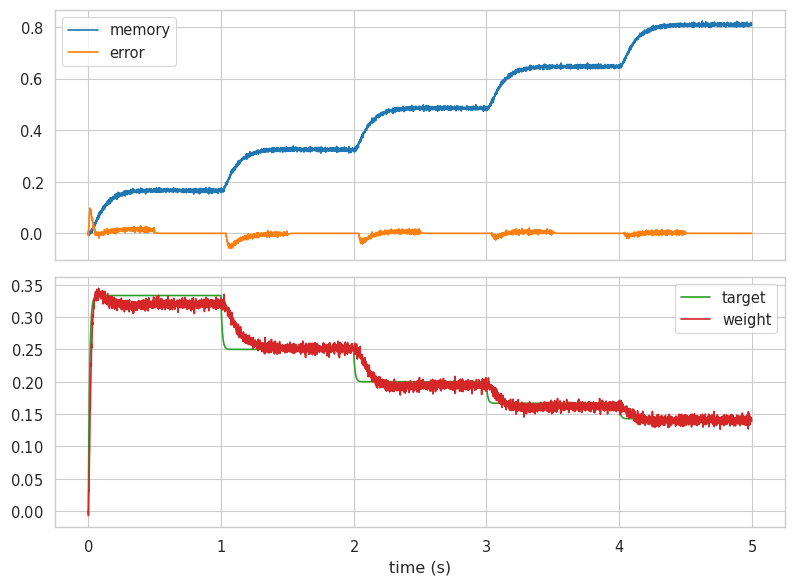

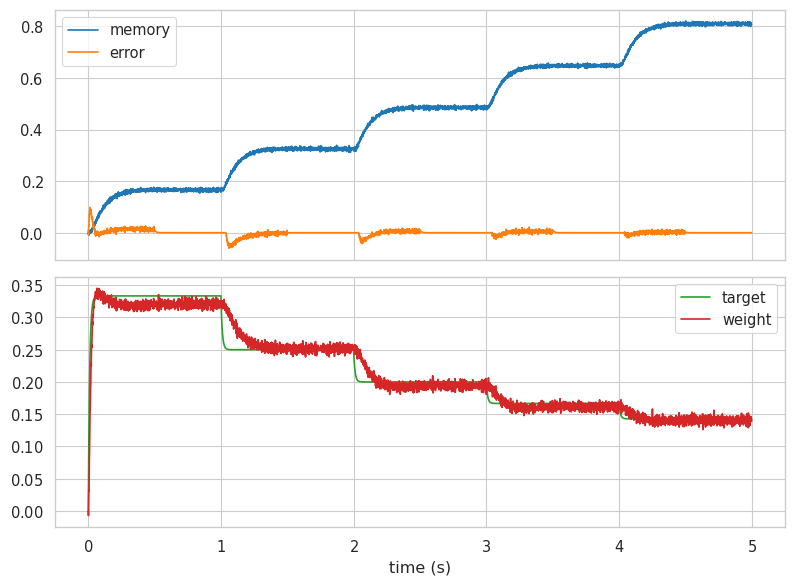

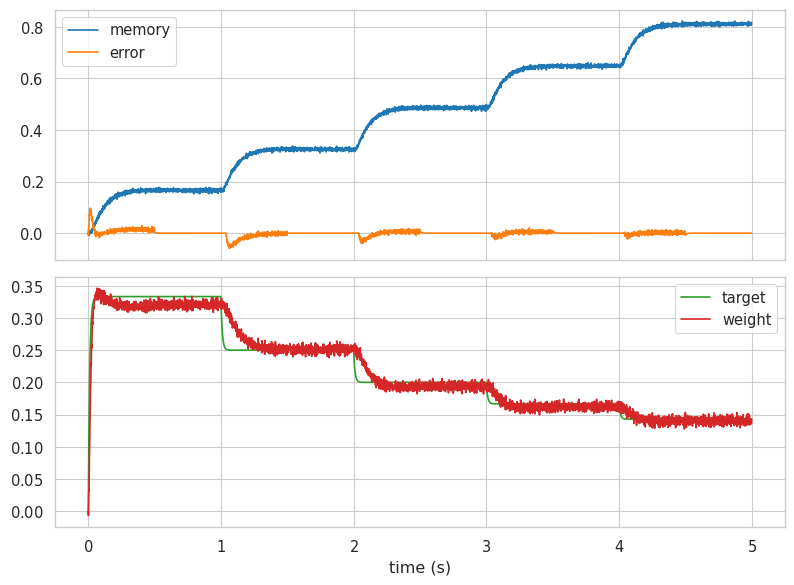

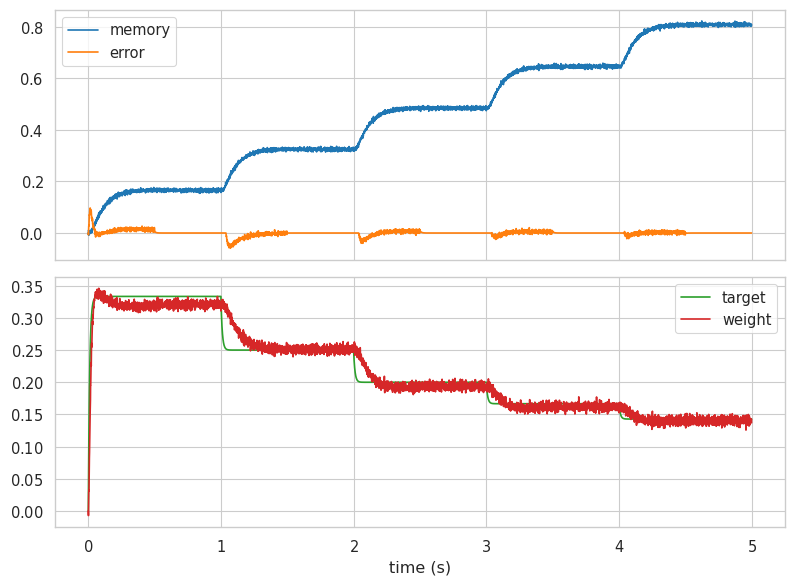

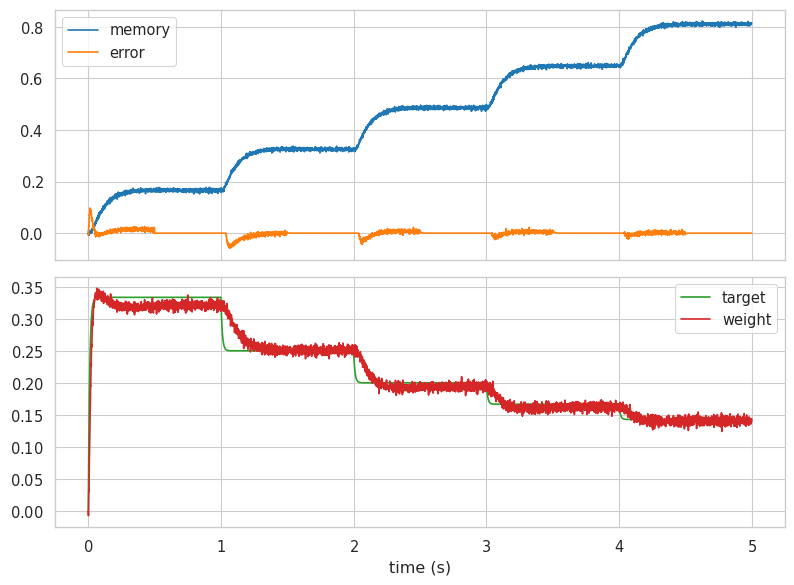

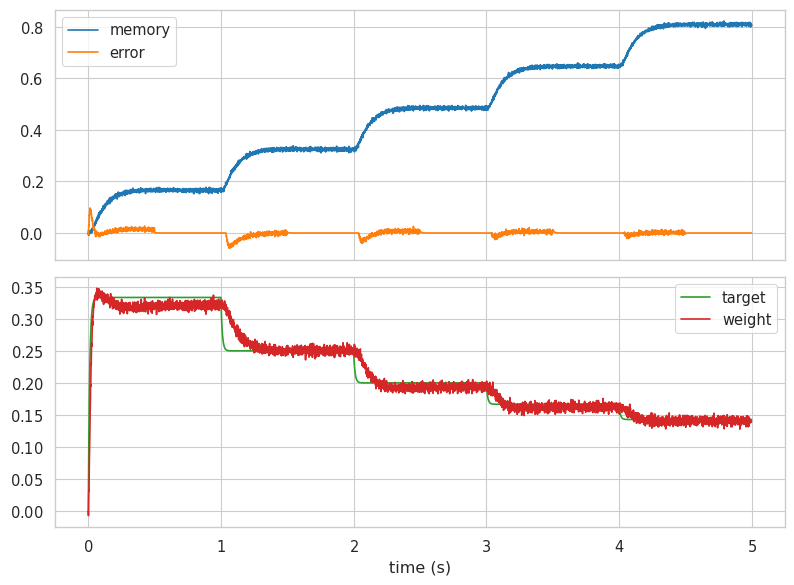

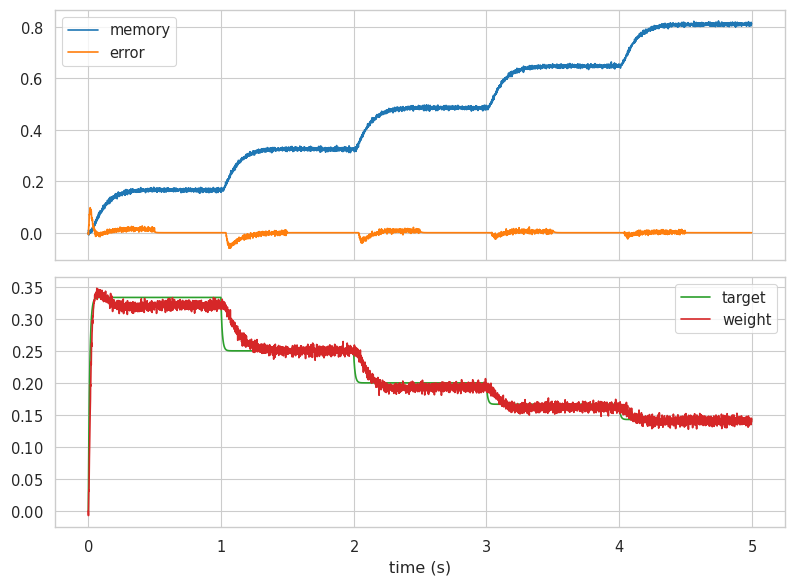

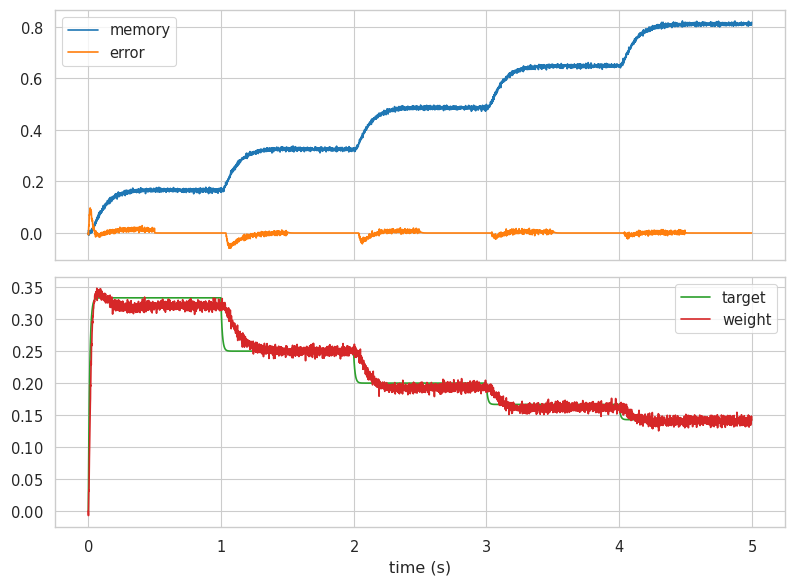

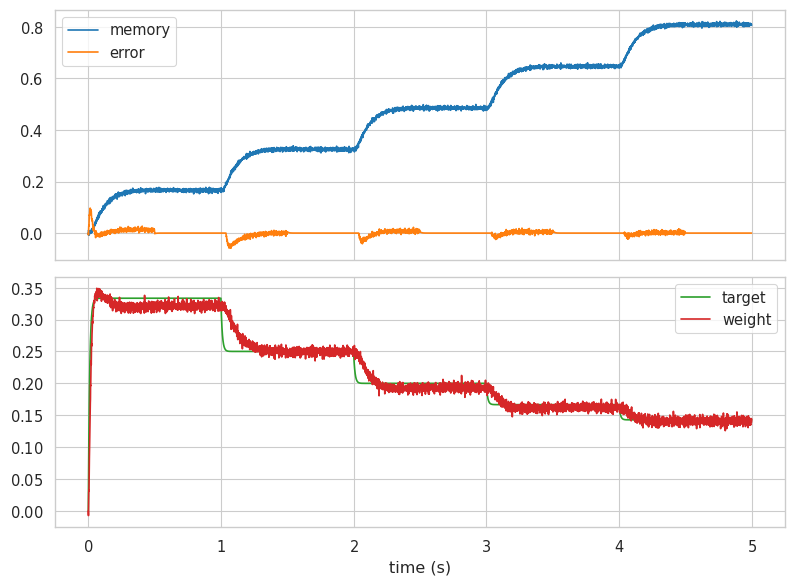

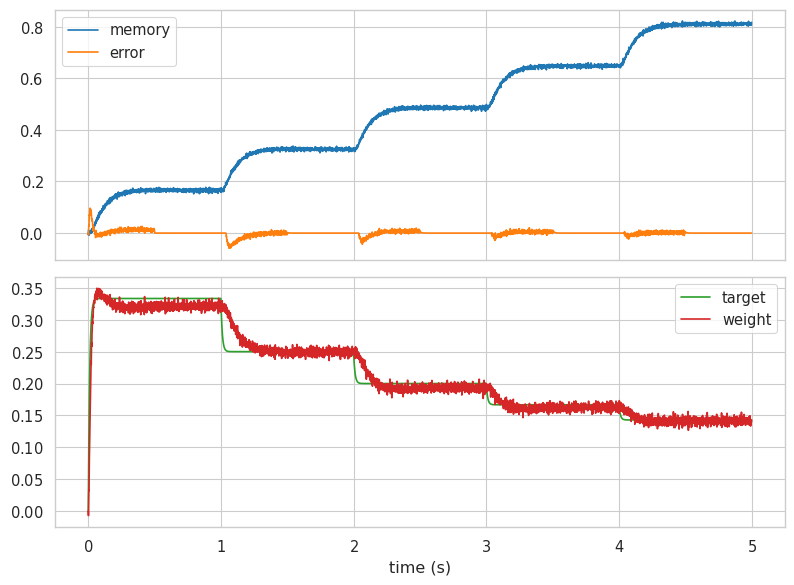

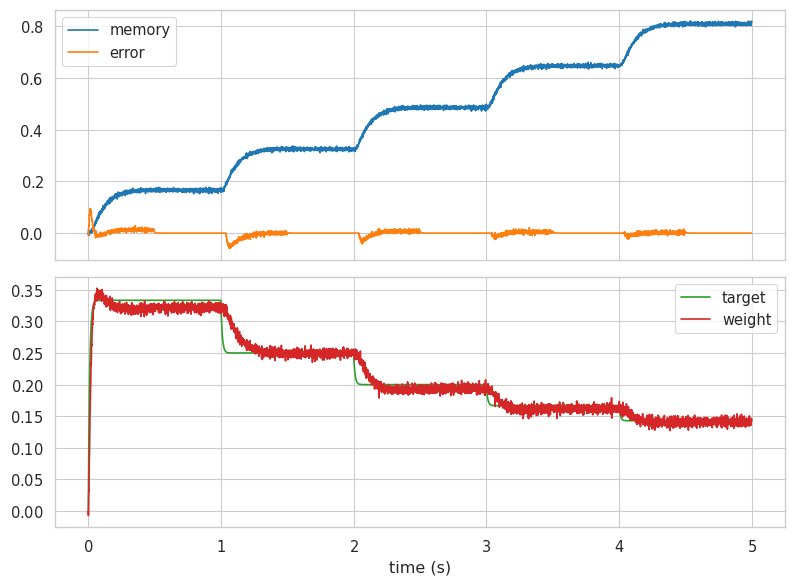

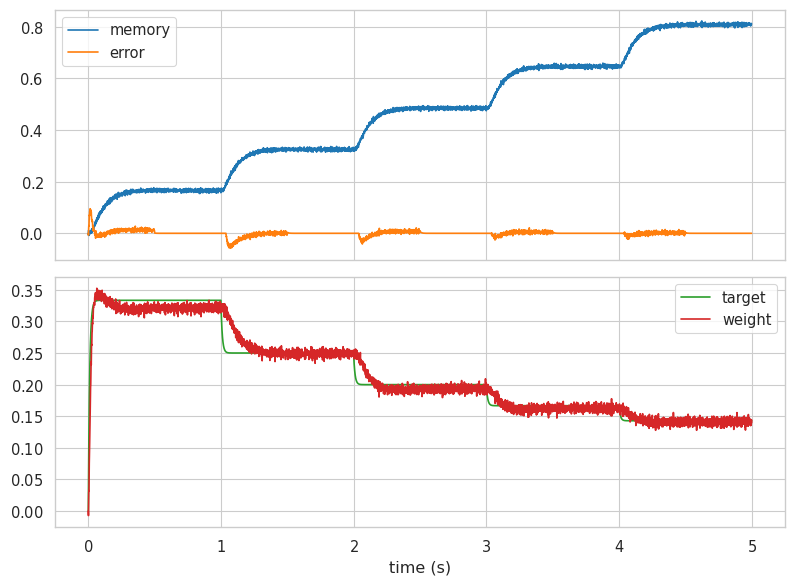

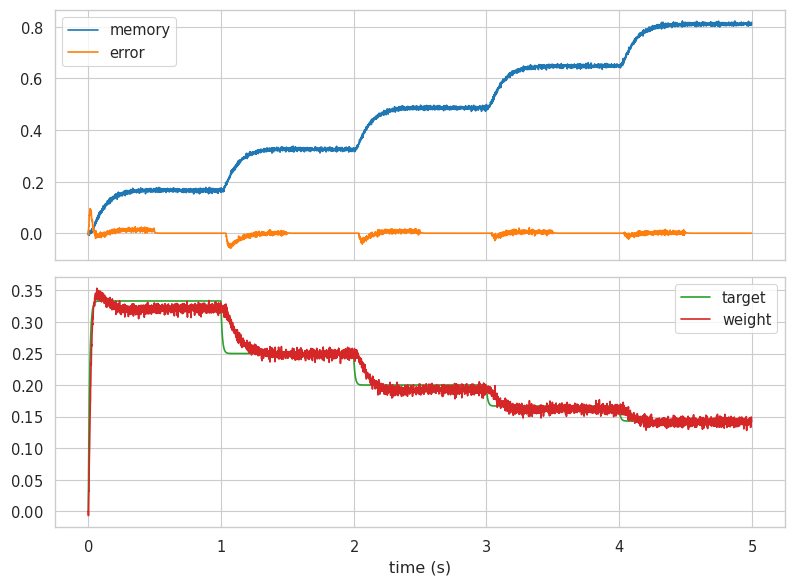

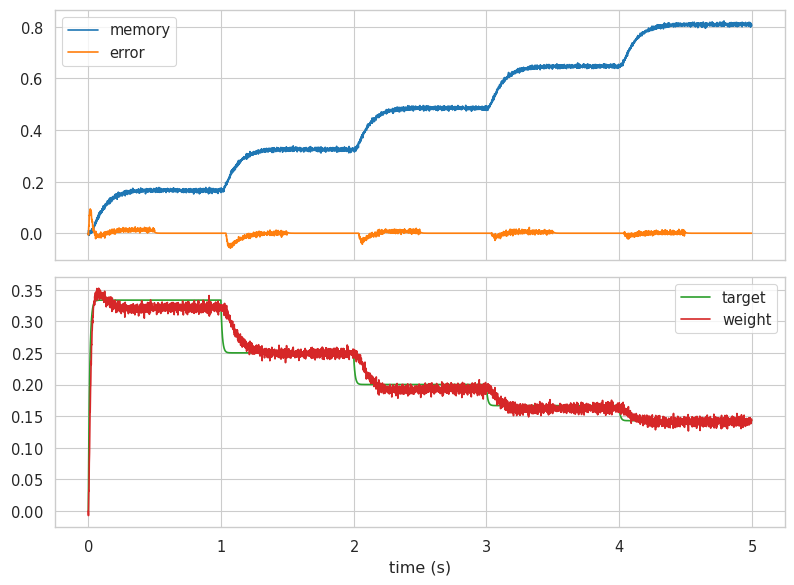

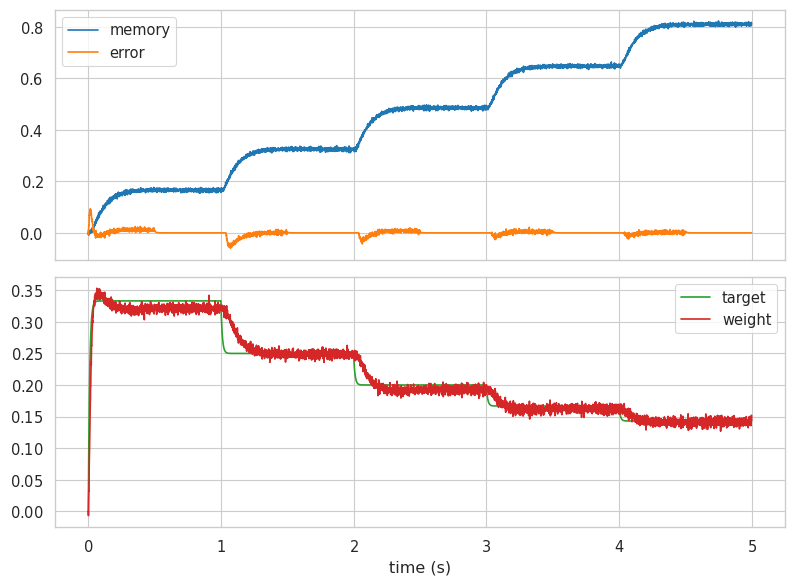

In [178]:
n_neurons = 1000
training_trials = 40
lambd = 1.0
W = np.zeros((1, n_neurons))
for t in range(1, training_trials+1):
    print(f"training iteration {t}")
    env = EnvironmentRec('carrabin', sid=1, trial=t)
    W = build_network_syn(W, env, n_neurons=n_neurons, lambd=lambd, train=True)

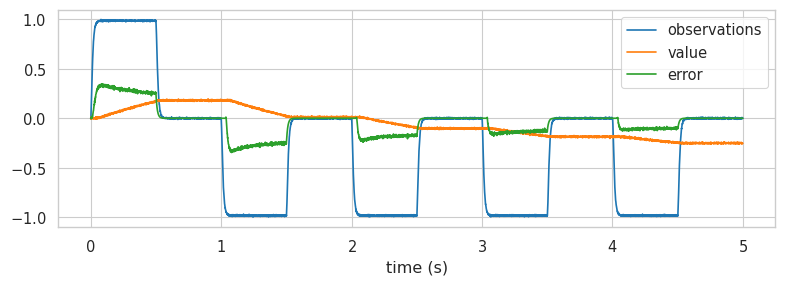

In [181]:
env = EnvironmentRec('carrabin', sid=1, trial=1)
net, sim = build_network_syn(W, env, n_neurons=n_neurons, lambd=lambd, train=False)

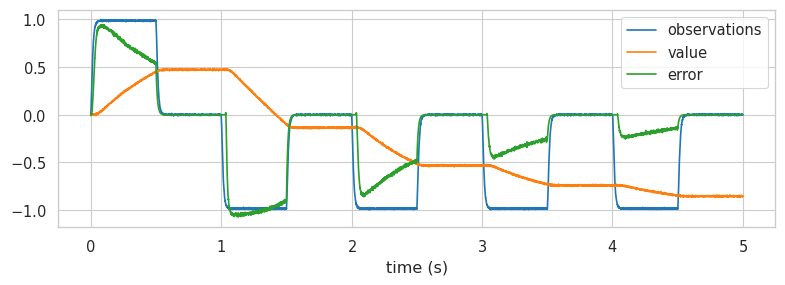

In [175]:
env = EnvironmentRec('carrabin', sid=1, trial=1)
net, sim = build_network_syn(W, env, n_neurons=n_neurons, lambd=0, train=False)

# Add in NEF_rec components

In [199]:
def build_network_rec(learned_weights, env, n_neurons=1000, seed_net=0, syn=0.01, syn_fb=0.2,
                      radius=1, a=1e-4, alpha=0.2, dt=0.001, lambd=0, train=False):
    func_stim = lambda t: env.sample(t)
    func_weight = lambda t: np.power(int(t)+3, -lambd) if t!=-3 else 1
    func_stop = lambda t: 1 - np.abs(env.sample(t))

    w_inh_weight = -1000*np.ones((n_neurons, 1))
    w_inh_value = -1000*np.ones((int(n_neurons/2), 1))
    
    network = nengo.Network(seed=seed_net)
    with network:
        node_stim = nengo.Node(func_stim)
        node_target = nengo.Node(func_weight)
        node_stop = nengo.Node(func_stop)
        
        stim = nengo.Ensemble(n_neurons, 1, seed=seed_net)
        delta = nengo.Ensemble(n_neurons, 1, encoders=nengo.dists.Choice([[1]]), intercepts=nengo.dists.Uniform(0,1), seed=seed_net)
        memory = nengo.Ensemble(n_neurons, 1, radius=radius, seed=seed_net)    
        weight = nengo.Ensemble(n_neurons, 1, seed=seed_net)
        value = nengo.Ensemble(n_neurons, 1, seed=seed_net)
        if train:
            error_weight = nengo.Ensemble(n_neurons, 1, seed=seed_net)
        else:
            error_value = nengo.networks.Product(n_neurons, 1, seed=seed_net)

        nengo.Connection(node_stim, stim, seed=seed_net)
        nengo.Connection(stim, delta, synapse=syn, function=lambda x: 2*np.abs(x), seed=seed_net)
        nengo.Connection(stim, delta, synapse=0.1, function=lambda x: -2*np.abs(x), seed=seed_net)
        nengo.Connection(delta, memory, synapse=syn_fb, transform=syn_fb, seed=seed_net)
        nengo.Connection(memory, memory, synapse=syn_fb, seed=seed_net)
        nengo.Connection(value, value, synapse=syn_fb, seed=seed_net)
        if train:
            conn_weight = nengo.Connection(memory.neurons, weight, synapse=syn, seed=seed_net,
                                           transform=learned_weights, learning_rule_type=nengo.PES(learning_rate=a))
            nengo.Connection(node_target, error_weight, transform=1, seed=seed_net)
            nengo.Connection(weight, error_weight, transform=-1, seed=seed_net)
            nengo.Connection(error_weight, conn_weight.learning_rule, transform=-1, seed=seed_net)
            nengo.Connection(node_stop, error_weight.neurons, transform=w_inh_weight, seed=seed_net)
        else:
            conn_weight = nengo.Connection(memory.neurons, weight, transform=learned_weights, synapse=syn, seed=seed_net)
            nengo.Connection(stim, error_value.input_a, synapse=syn)
            nengo.Connection(value, error_value.input_a, transform=-1, synapse=syn, seed=seed_net)
            nengo.Connection(weight, error_value.input_b, synapse=syn, seed=seed_net)
            nengo.Connection(error_value.output, value, transform=alpha, synapse=syn_fb, seed=seed_net)
            nengo.Connection(node_stop, error_value.sq1.ea_ensembles[0].neurons, transform=w_inh_value, seed=seed_net)
            nengo.Connection(node_stop, error_value.sq2.ea_ensembles[0].neurons, transform=w_inh_value, seed=seed_net)

        probe_stim = nengo.Probe(stim, synapse=syn)
        probe_target = nengo.Probe(node_target, synapse=syn)
        probe_delta = nengo.Probe(delta, synapse=syn)
        probe_memory = nengo.Probe(memory, synapse=syn)
        probe_weight = nengo.Probe(weight, synapse=syn)
        probe_value = nengo.Probe(value, synapse=syn)
        if train:
            probe_error_weight = nengo.Probe(error_weight, synapse=0.01)
            probe_learned_weights = nengo.Probe(conn_weight, "weights")
        else:
            probe_error_value = nengo.Probe(error_value.output, synapse=0.01)
            

    sim = nengo.Simulator(network, dt=dt, progress_bar=False)
    with sim:
        sim.run(5-dt)

    if train:
        learned_weights = sim.data[probe_learned_weights][-1]
        with sns.axes_style("whitegrid"):  # This enables gridlines
            fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(8,6))
            # sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_stim].flatten(), label='observations', color=palette[0], ax=axes[0])
            sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_memory].flatten(), label='memory', color=palette[0], ax=axes[0])
            sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_error_weight].flatten(), label='error', color=palette[1], ax=axes[0])
            sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_target].flatten(), label='target', color=palette[2], ax=axes[1])
            sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_weight].flatten(), label='weight', color=palette[3], ax=axes[1])
            # axes[0].set(title=f"training iteration {seed_stim}")
            axes[1].set(xlabel='time (s)')
            plt.grid(True, axis='y')  # Enable only y-axis gridlines
            fig.tight_layout()
            plt.show()
            plt.close('all')
    else:
        with sns.axes_style("whitegrid"):  # This enables gridlines
            fig, axes = plt.subplots(nrows=1, sharex=True, figsize=(8,3))
            sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_stim].flatten(), label='observations', color=palette[0], ax=axes)
            sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_value].flatten(), label='value', color=palette[1], ax=axes)
            sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_error_value].flatten(), label='error', color=palette[2], ax=axes)
            axes.set(xlabel='time (s)')
            plt.grid(True, axis='y')  # Enable only y-axis gridlines
            fig.tight_layout()
    if train:
        return learned_weights
    else:
        return network, sim

training iteration 1


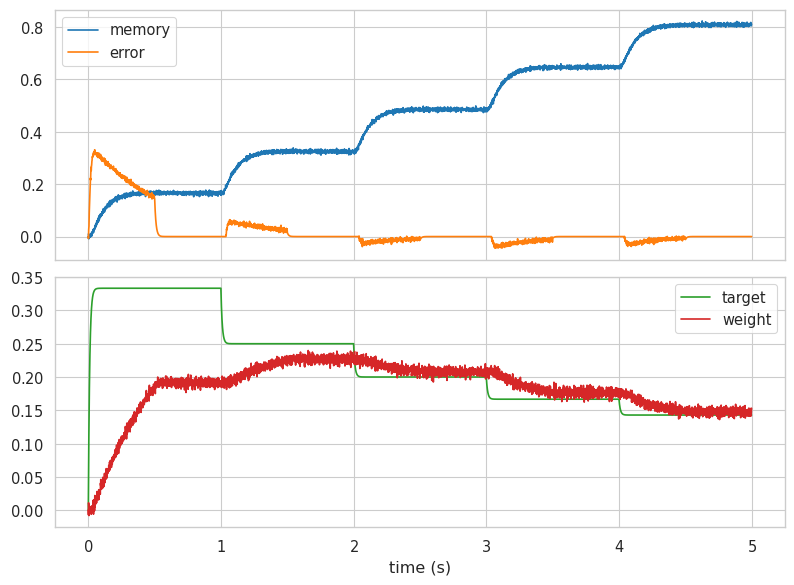

training iteration 2


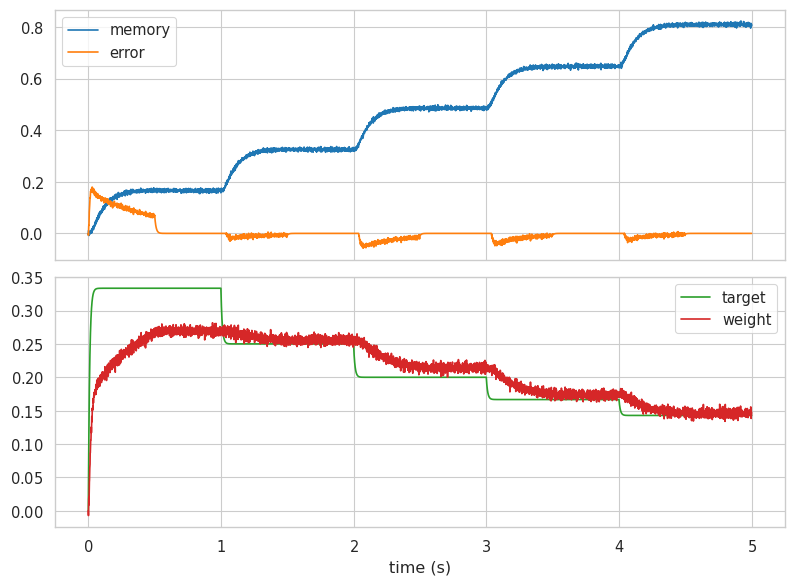

training iteration 3


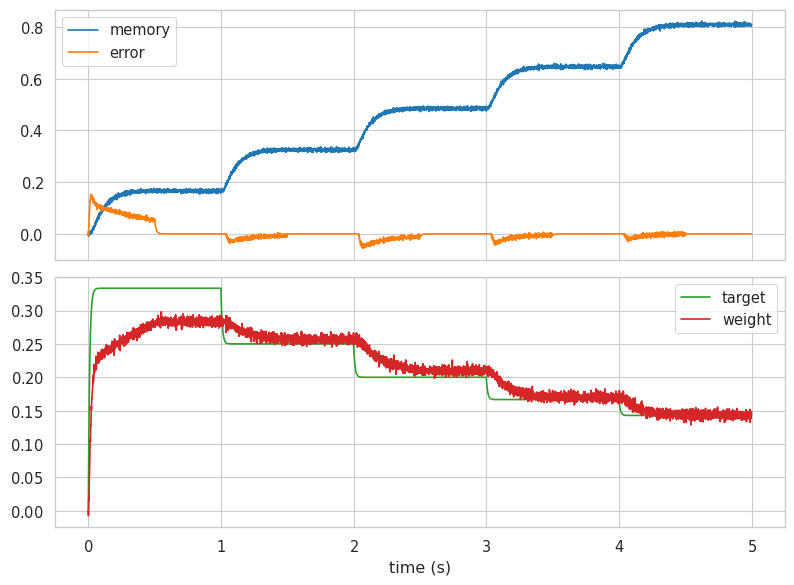

training iteration 4


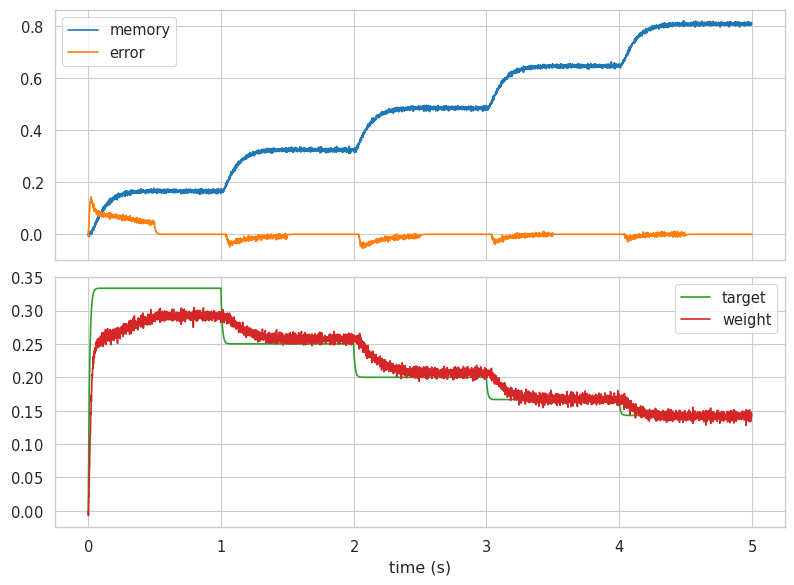

training iteration 5


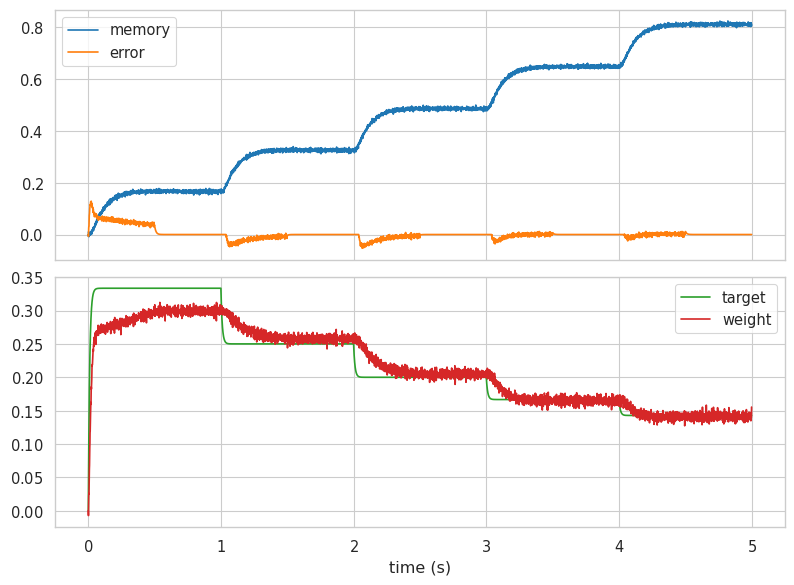

training iteration 6


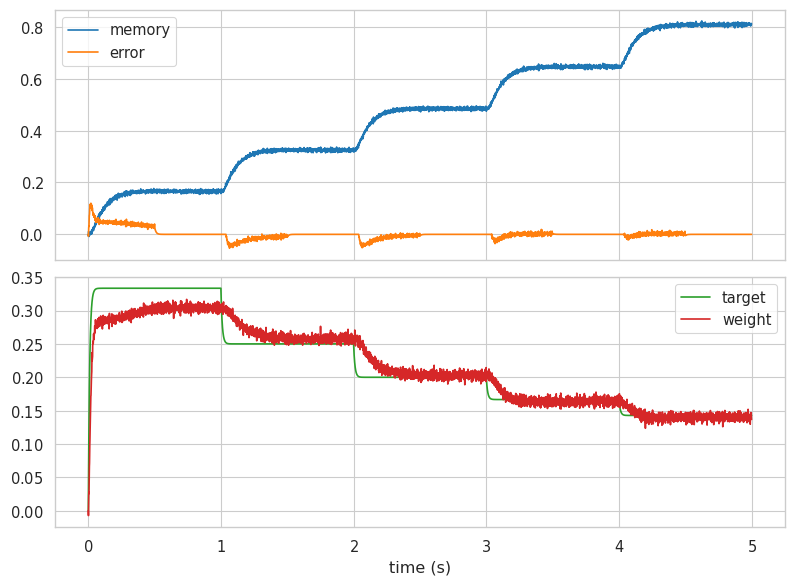

training iteration 7


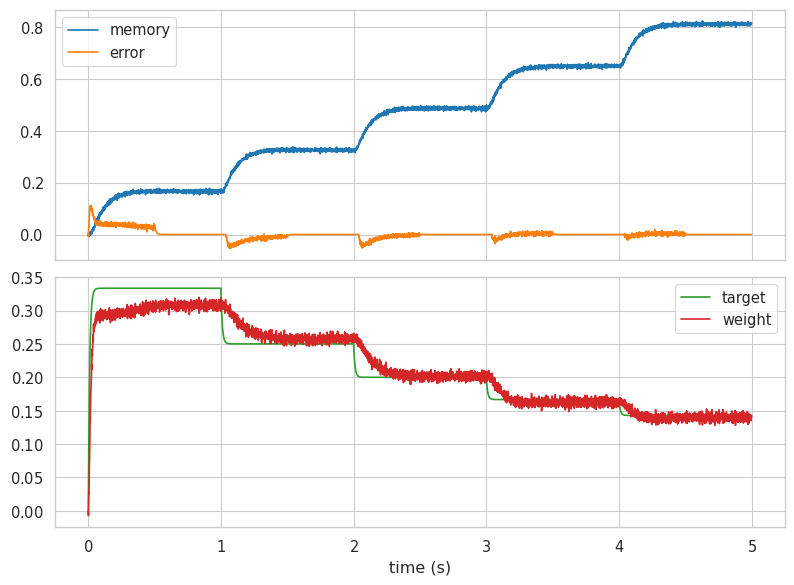

training iteration 8


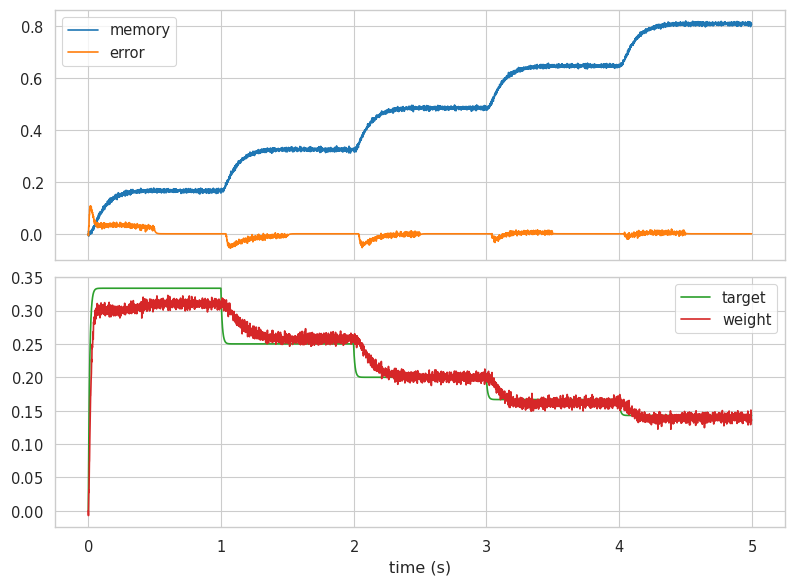

training iteration 9


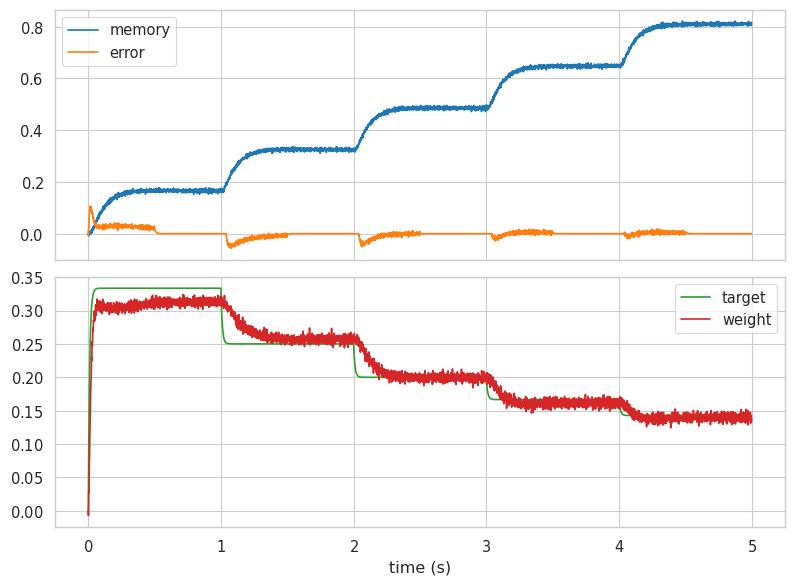

training iteration 10


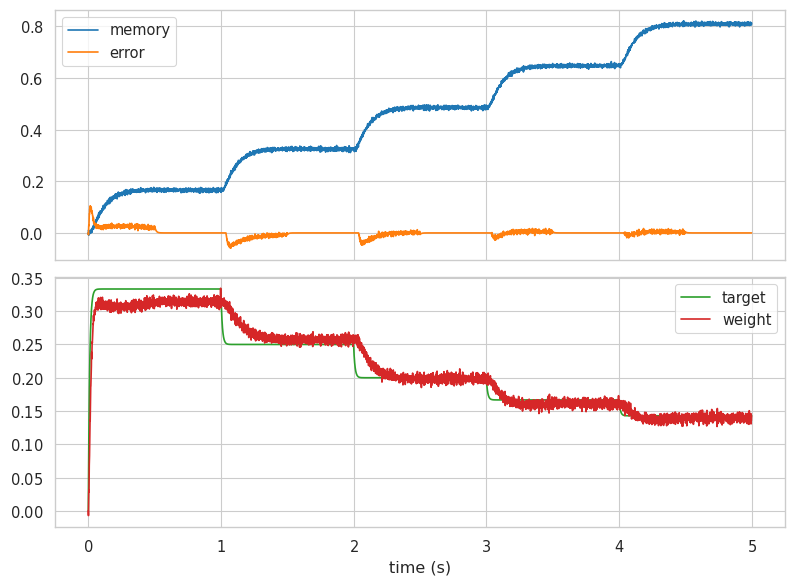

training iteration 11


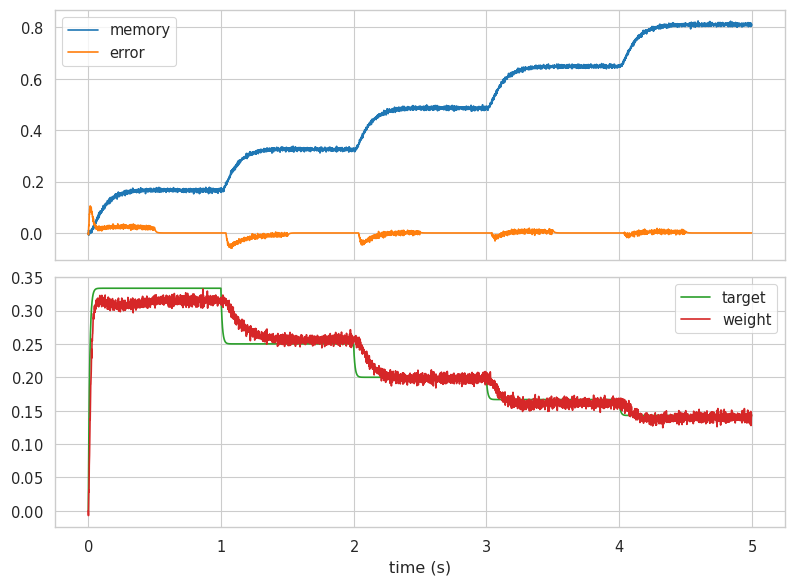

training iteration 12


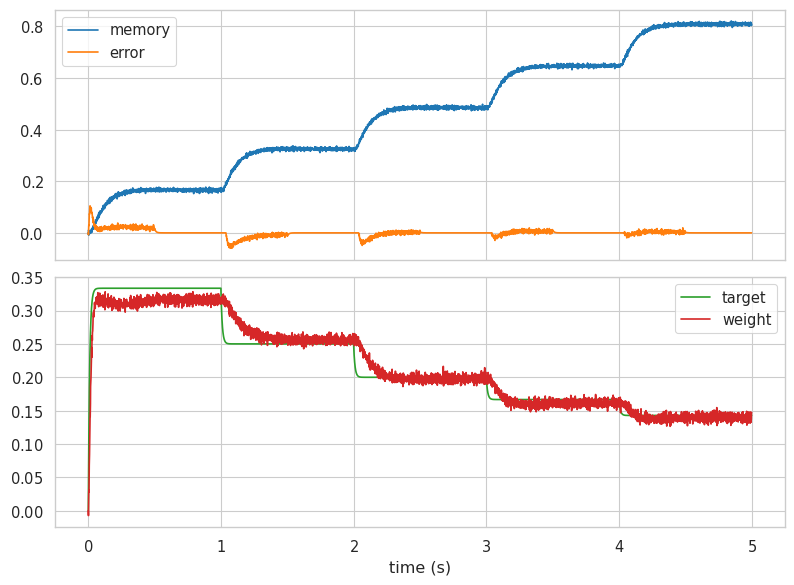

training iteration 13


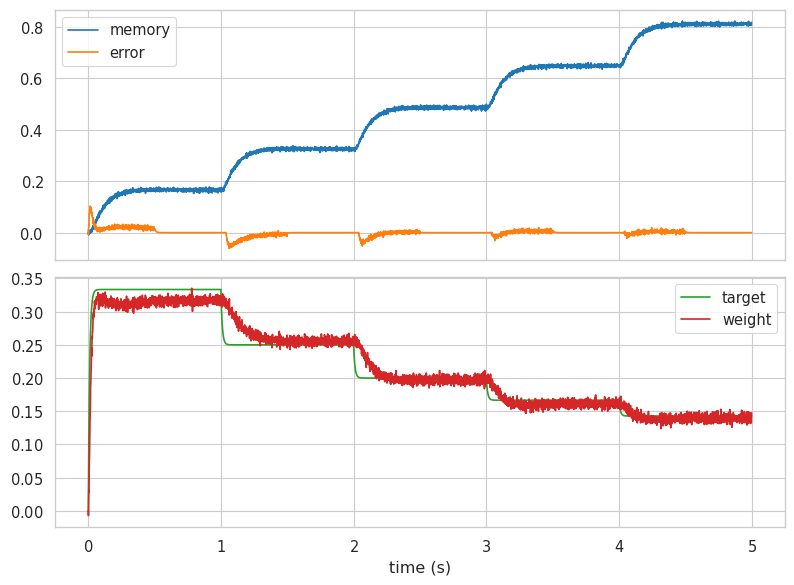

training iteration 14


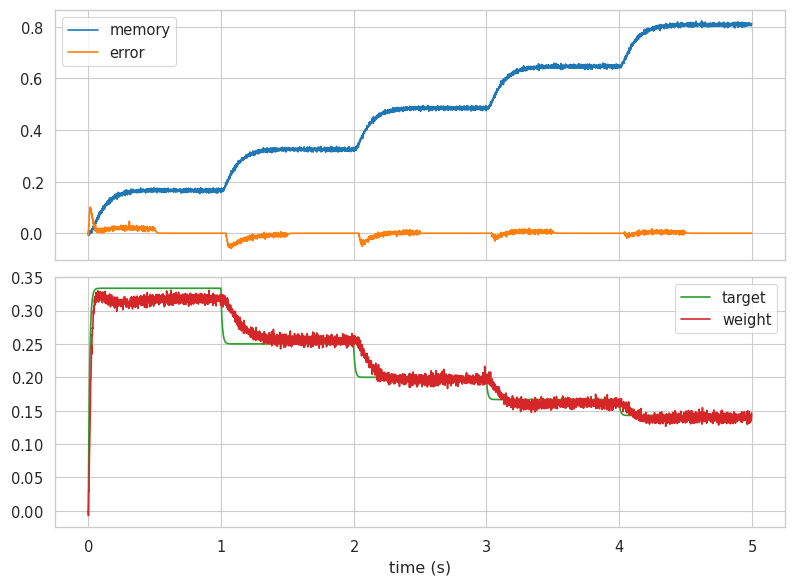

training iteration 15


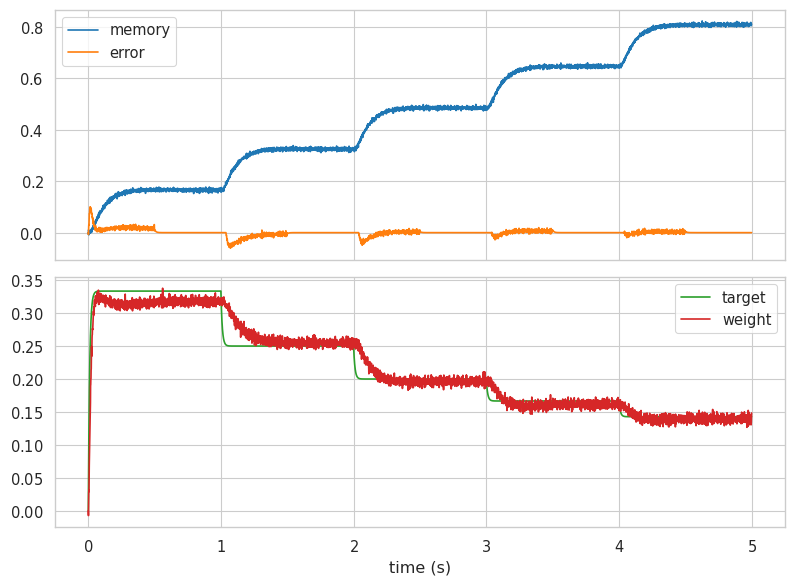

training iteration 16


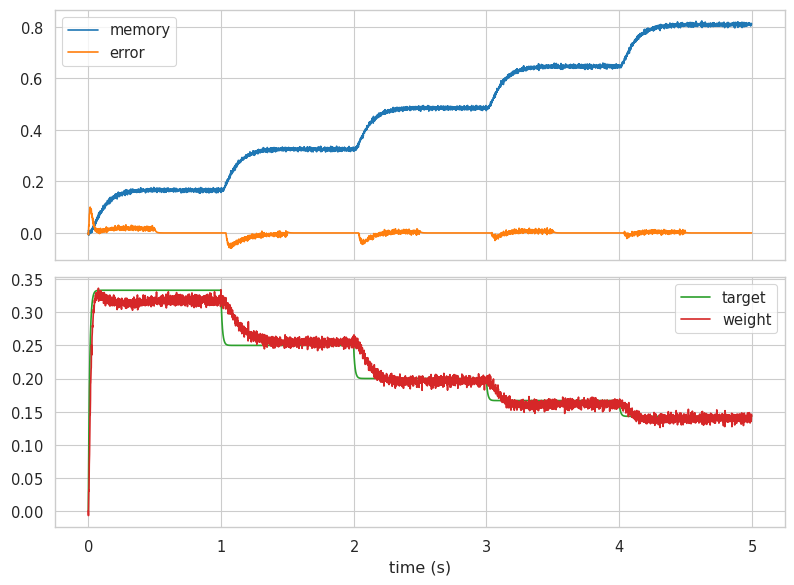

training iteration 17


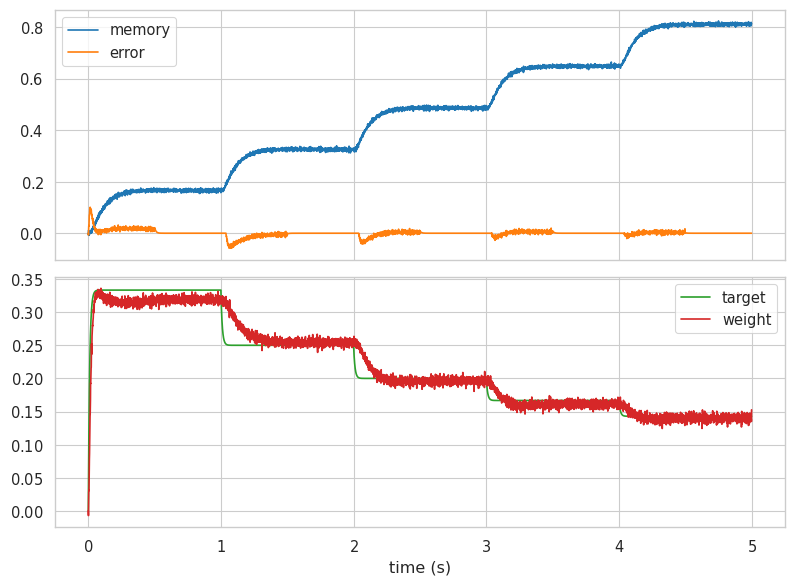

training iteration 18


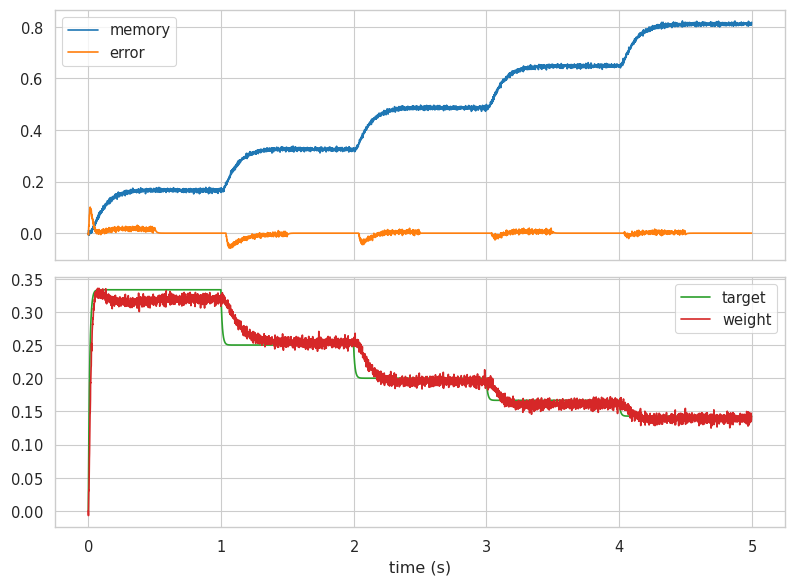

training iteration 19


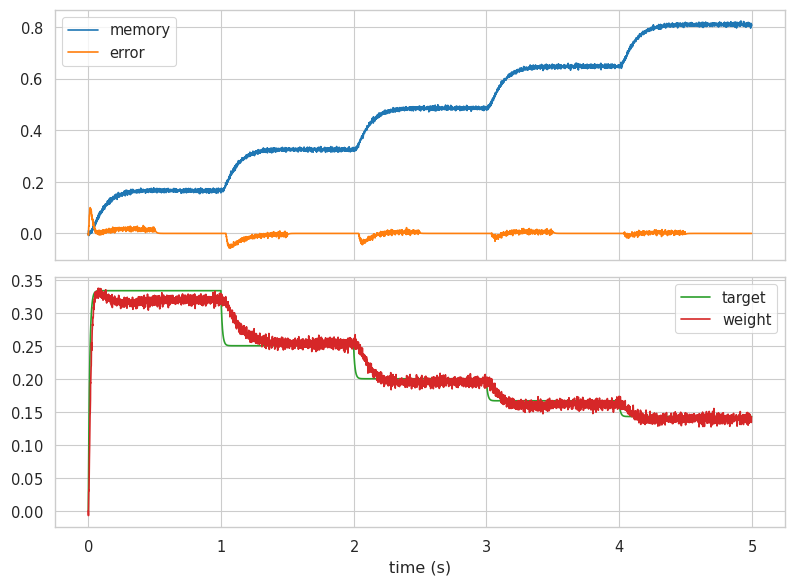

training iteration 20


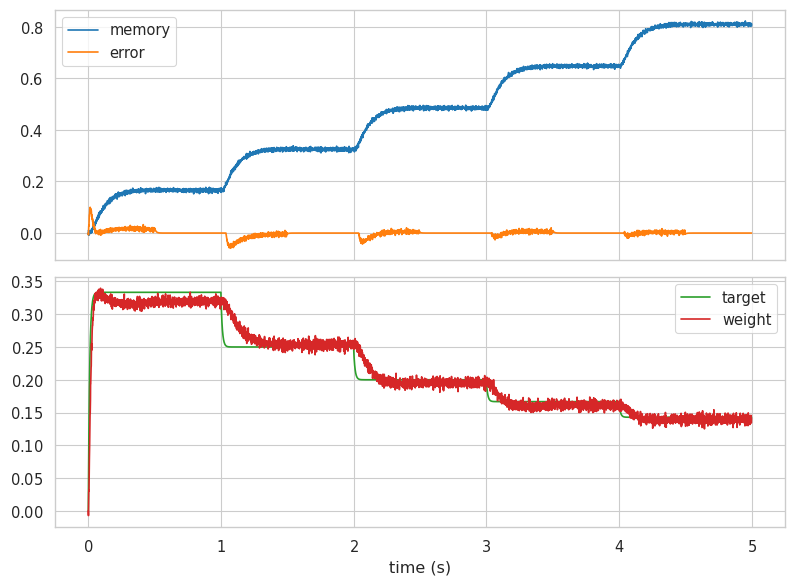

training iteration 21


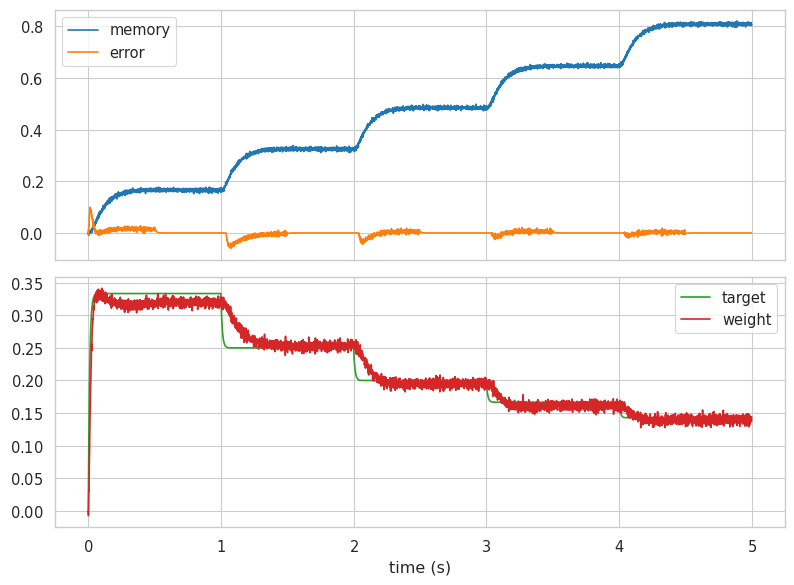

training iteration 22


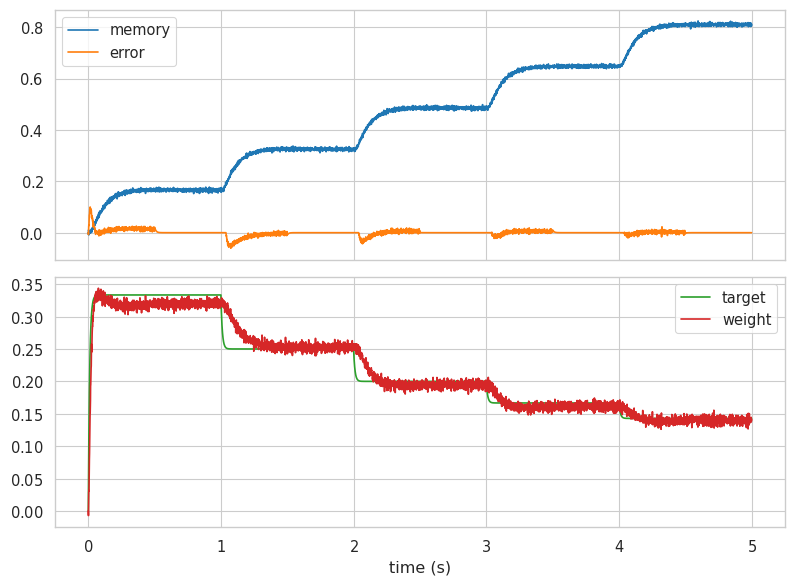

training iteration 23


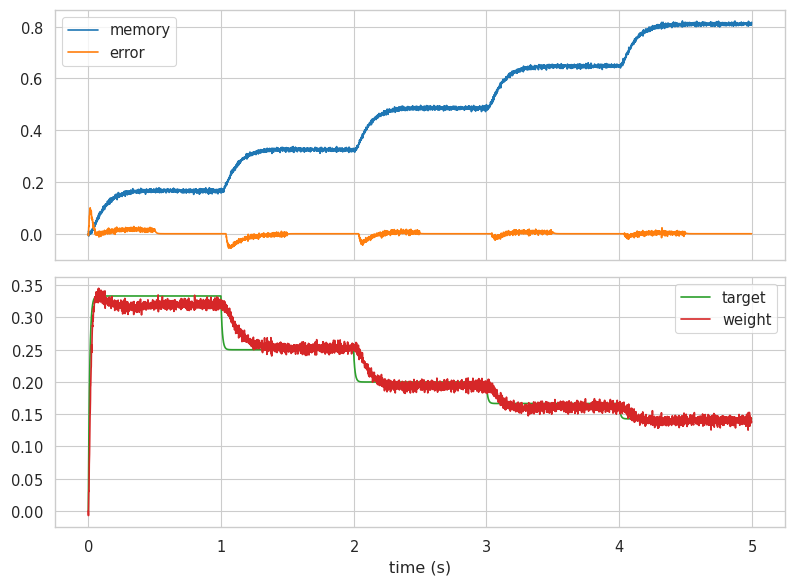

training iteration 24


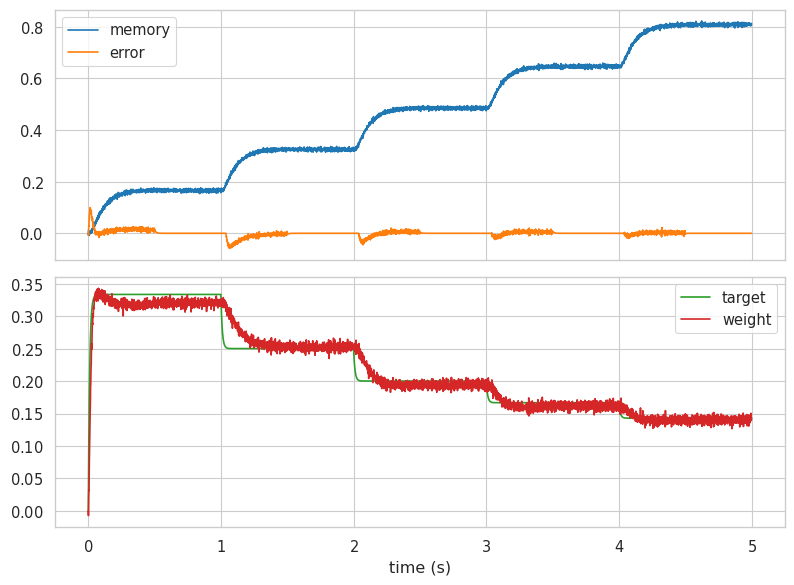

training iteration 25


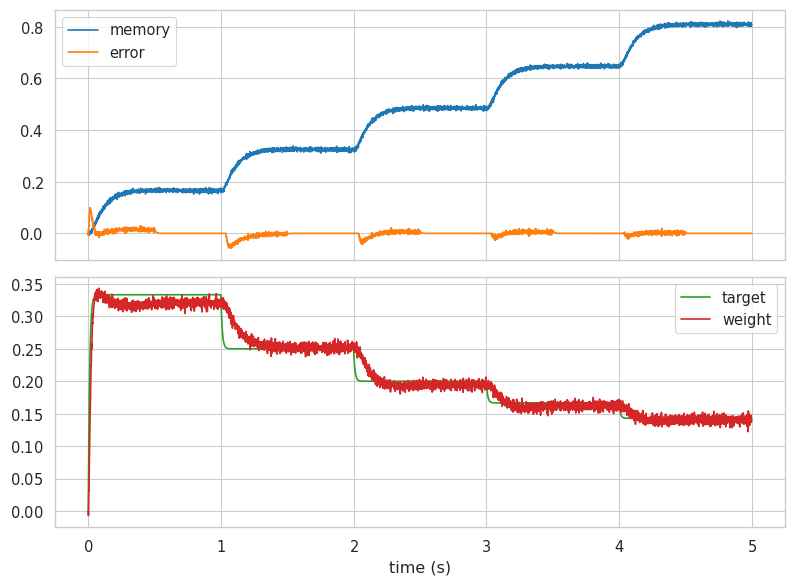

training iteration 26


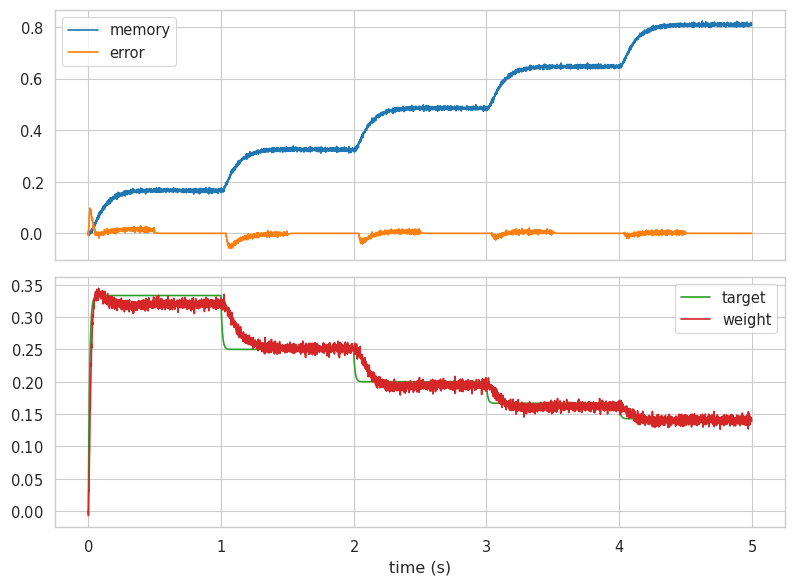

training iteration 27


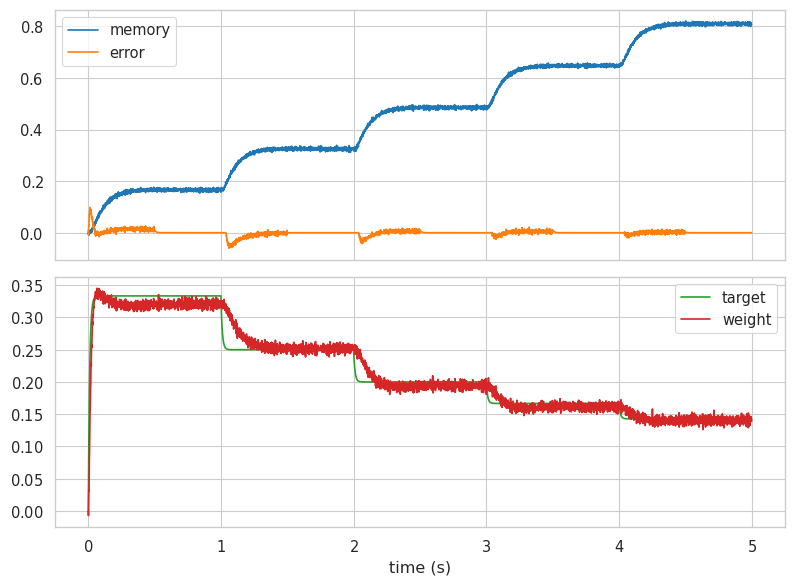

training iteration 28


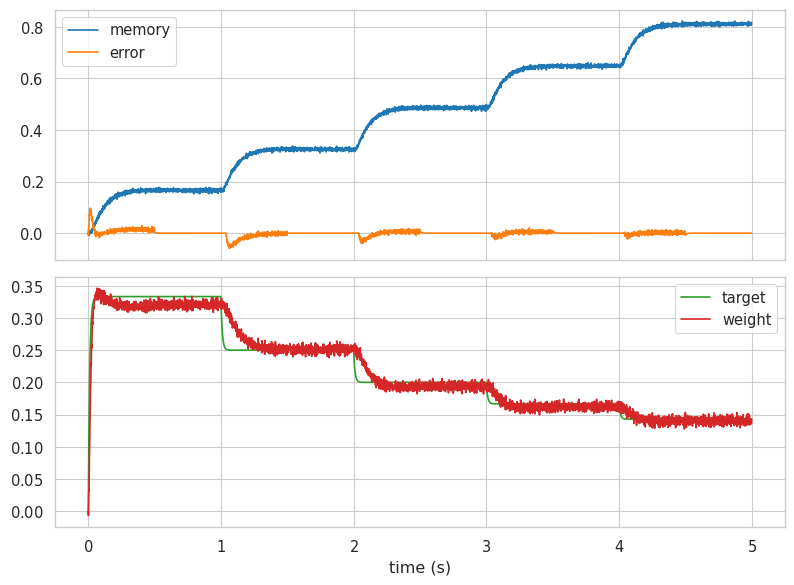

training iteration 29


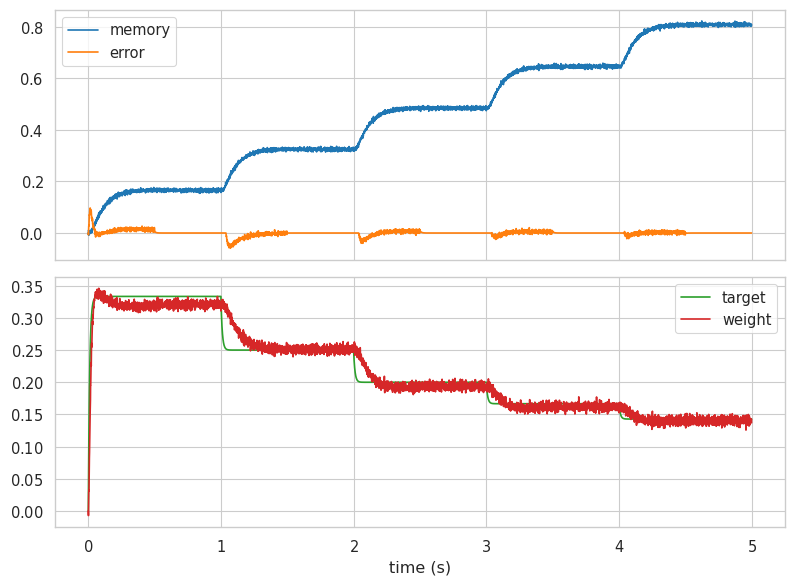

training iteration 30


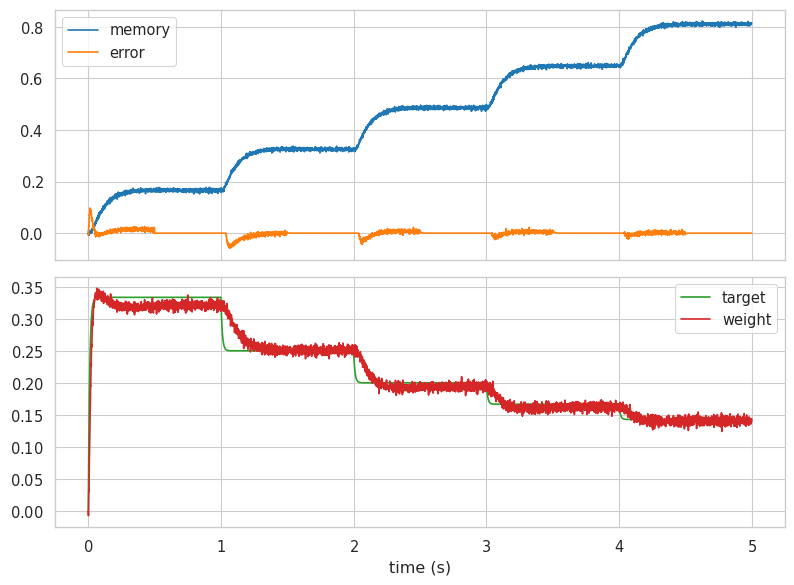

training iteration 31


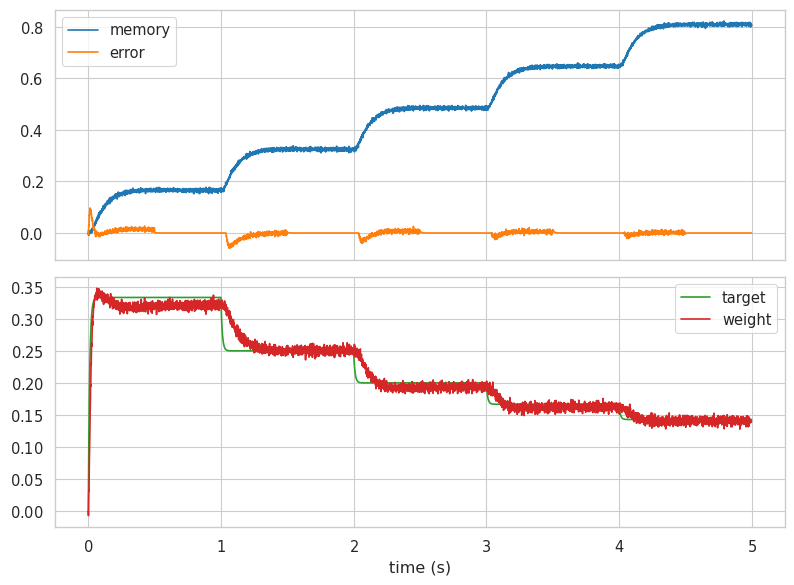

training iteration 32


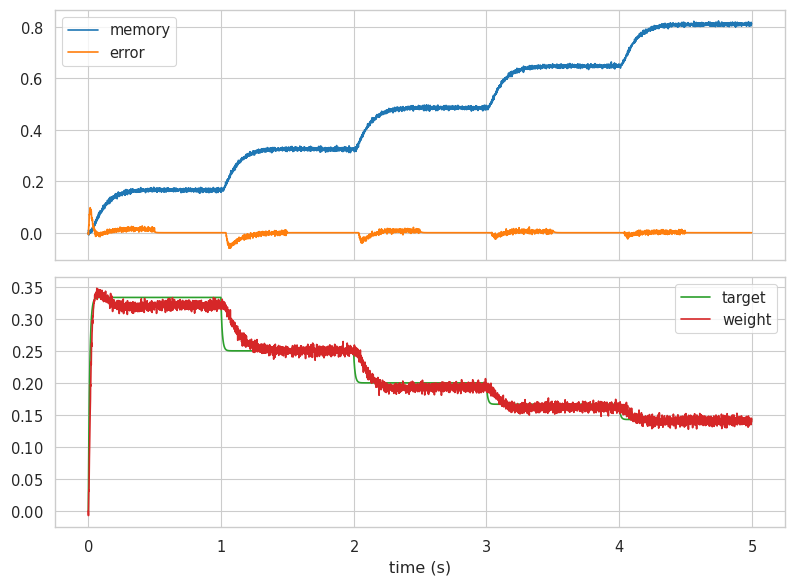

training iteration 33


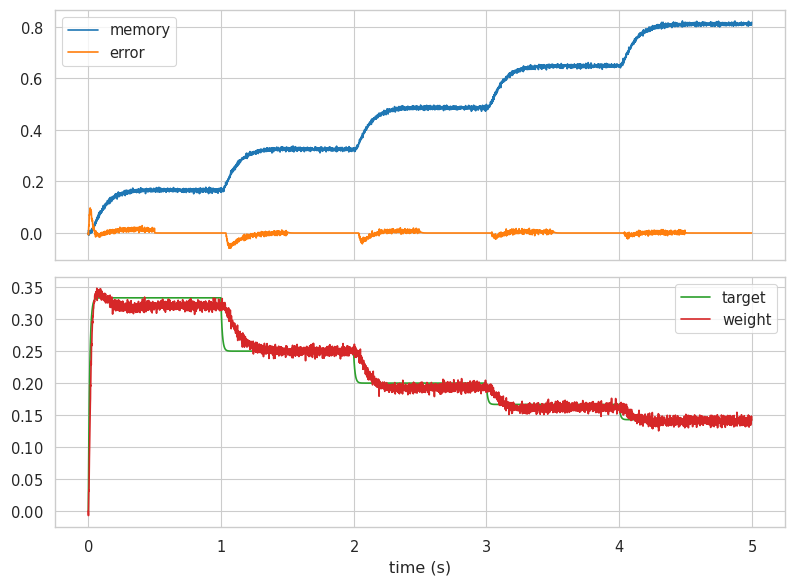

training iteration 34


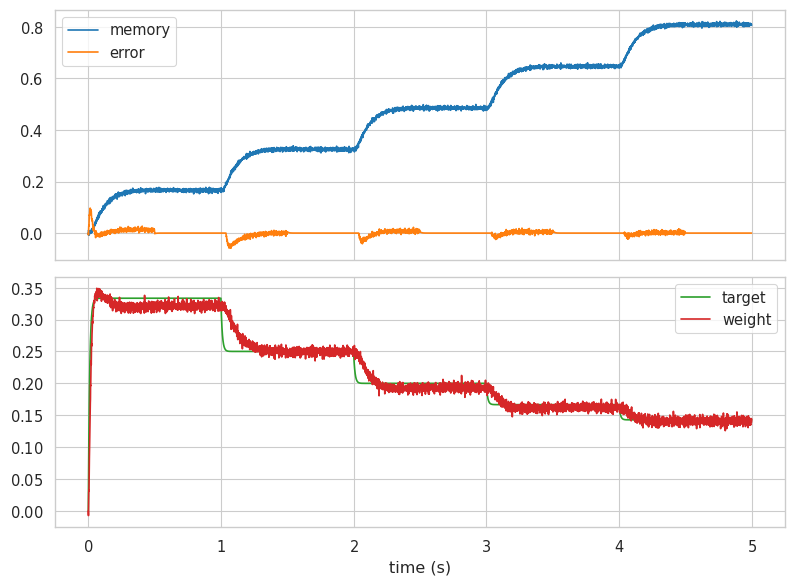

training iteration 35


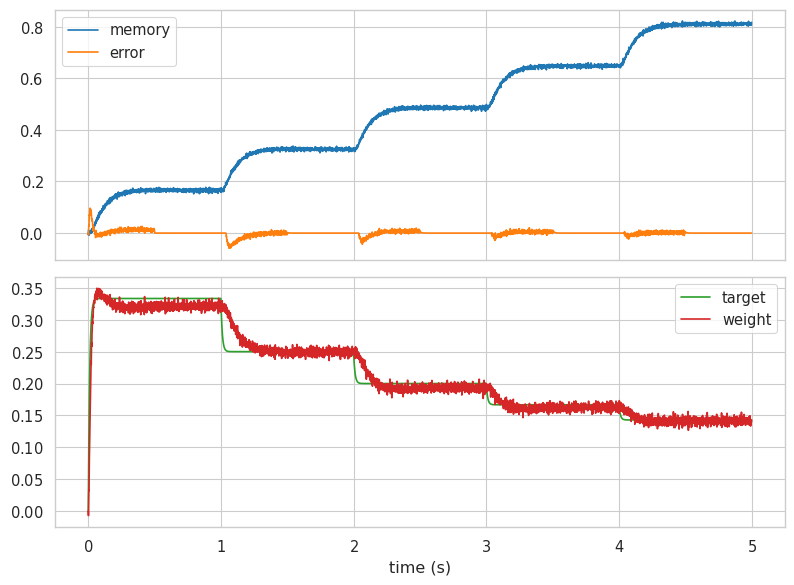

training iteration 36


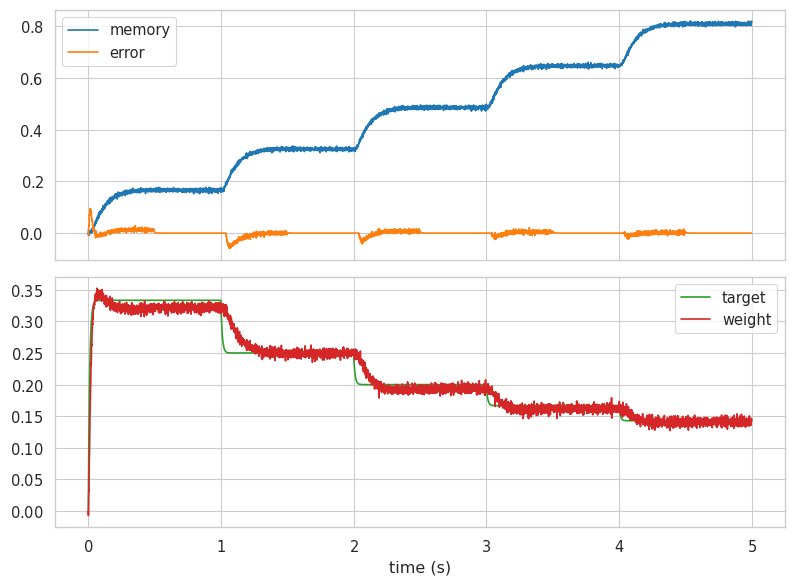

training iteration 37


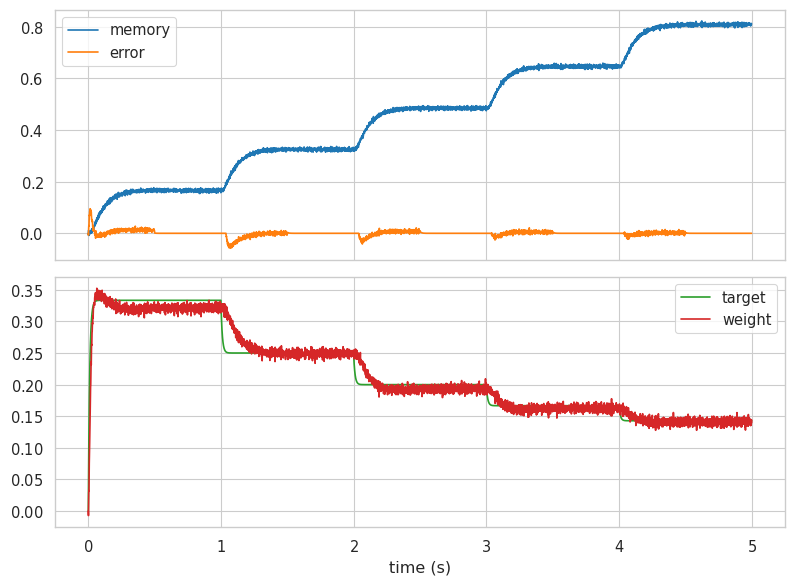

training iteration 38


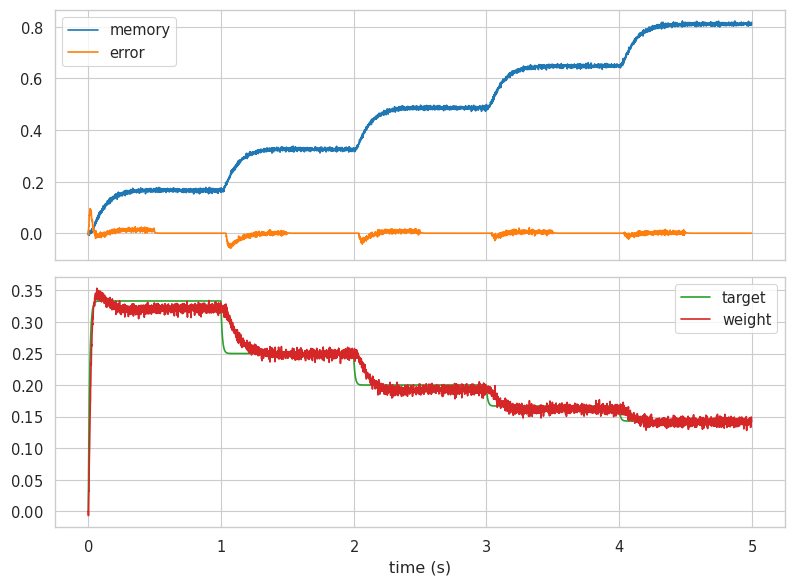

training iteration 39


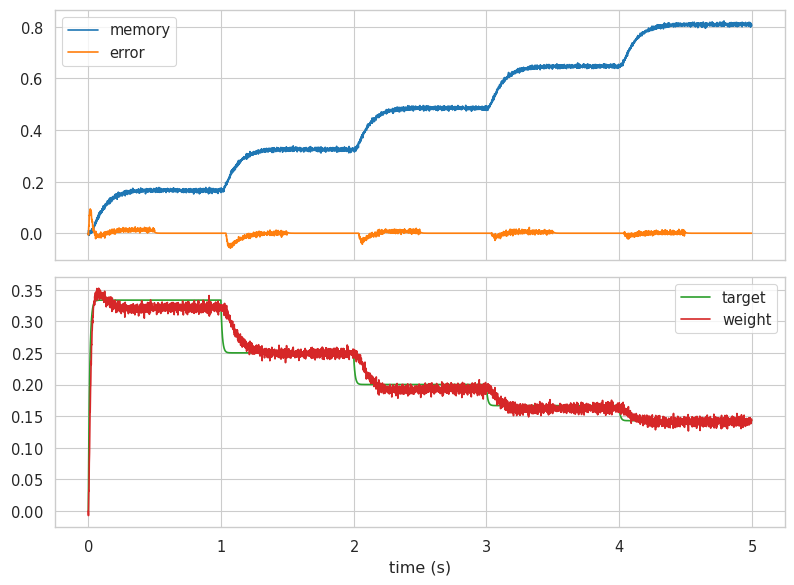

training iteration 40


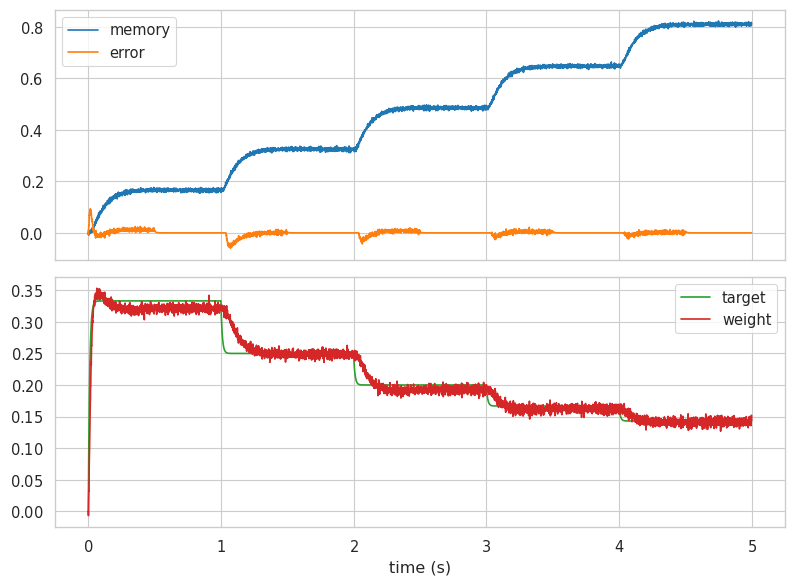

In [201]:
n_neurons = 1000
training_trials = 40
lambd = 1.0
W = np.zeros((1, n_neurons))
for t in range(1, training_trials+1):
    print(f"training iteration {t}")
    env = EnvironmentRec('carrabin', sid=1, trial=t)
    W = build_network_rec(W, env, n_neurons=n_neurons, lambd=lambd, train=True)

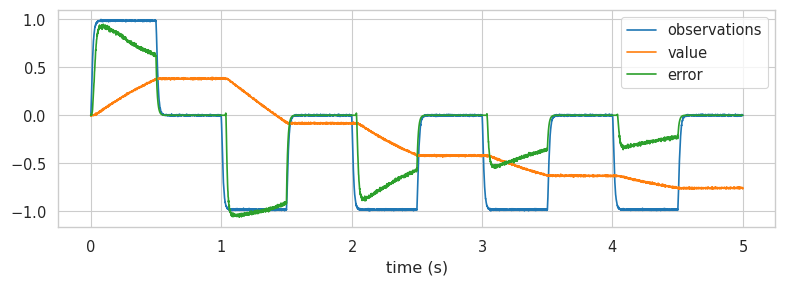

In [200]:
env = EnvironmentRec('carrabin', sid=1, trial=1)
net, sim = build_network_rec(W, env, n_neurons=n_neurons, lambd=lambd, train=False)

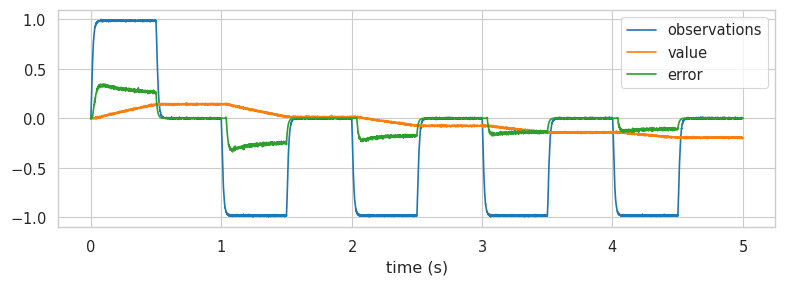

In [202]:
env = EnvironmentRec('carrabin', sid=1, trial=1)
net, sim = build_network_rec(W, env, n_neurons=n_neurons, lambd=lambd, train=False)